In [2]:
import subprocess 
import torch as ch
from torch import Tensor
import torch.linalg as LA
from torch.distributions import Uniform, Laplace
from torch.distributions.multivariate_normal import MultivariateNormal
import pandas as pd
import numpy as np
import csv
import json
from cox.utils import Parameters
from cox.store import Store

from cox.readers import CollectionReader
import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import math 

import sys 
sys.path.append('../..')
from delphi.stats.linear_regression import TruncatedRegression
from delphi import oracle
from delphi.utils import constants as consts
from delphi.utils.helpers import setup_store_with_metadata


OUT_DIR = '/home/gridsan/stefanou/Regression/'
TABLE_NAME = 'logs'

# set environment variable so that stores can create output files
os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'

In [3]:
args = Parameters({
    "bias": True,
    "samples": 1000,
    "c": 0,
    "batch_size": 5,
    "lr": 1e-1,
    "var_": 1,
    "trials": 3,
    "workers": 8,
    "steps": 1000,
    "x_lower": -10,
    "x_upper": 10,
    "lower": -1,
    "upper": 1,
})
mse_loss = ch.nn.MSELoss()

I will start by generating the ground-truth for our expriment.

gt weight:  Parameter containing:
tensor([[1.]], requires_grad=True)
gt bias:  Parameter containing:
tensor([[1.]], requires_grad=True)
alpha:  tensor([0.4540])
gt ols coef:  [[1.0157692]]
gt ols intercept:  [1.066447]
trunc ols coef:  [[0.5316576]]
trunc ols intercept:  [-0.16779864]


Text(0, 0.5, 'y')

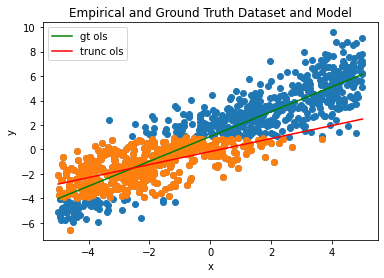

In [3]:
# distribution for generating feature vectors
d, k = 1, 1
# w = Uniform(-1, 1)
# m = MultivariateNormal(ch.zeros(d), ch.eye(d)/d)
m = Uniform(-5, 5)
# phi = oracle.Identity()
intervals = [(-8, -6), (-4, 1)]
phi = oracle.KIntervalUnion(intervals)

# generate ground truth
gt = ch.nn.Linear(in_features=k, out_features=1)
gt.weight = ch.nn.Parameter(ch.ones(k, d))

# gt.bias = ch.nn.Parameter(ch.ones(1, 1)) if args.bias else None
gt.bias = ch.nn.Parameter(ch.ones(1, 1)) if args.bias else None
print("gt weight: ", gt.weight)
print("gt bias: ", gt.bias)

# create base classifier
with ch.no_grad():
    # generate data
    X = m.sample(ch.Size([args.samples, d])) if isinstance(m, Uniform) else m.sample(ch.Size([args.samples]))
    y = gt(X)

noise_var = Tensor([2.0])[...,None]
# remove synthetic data from the computation graph
with ch.no_grad():
    # add noise to ground-truth pedictions
    noised = y + ch.sqrt(noise_var) * ch.randn(X.size(0), 1)
    # truncate based off of the standardized data
    indices = phi(noised).flatten().nonzero(as_tuple=False).flatten()
    y_trunc, x_trunc = noised[indices], X[indices]
    alpha = Tensor([y_trunc.size(0) / args.samples])
    print("alpha: ", alpha)
    
# ground-truth OLS
gt_ols = LinearRegression()
gt_ols.fit(X, noised)
print("gt ols coef: ", gt_ols.coef_)
print("gt ols intercept: ", gt_ols.intercept_)

trunc_ols = LinearRegression()
trunc_ols.fit(x_trunc, y_trunc)
trunc_ols_pred = trunc_ols.predict(x_trunc)
print("trunc ols coef: ", trunc_ols.coef_)
print("trunc ols intercept: ", trunc_ols.intercept_)

# data for plotting regressions
unnorm_data = np.linspace(-5, 5, 100).reshape(100, 1)
norm_data = np.linspace(-1, 1, 100).reshape(100, 1)

ax = plt.subplot(1, 1, 1)
plt.scatter(X, noised)
plt.scatter(x_trunc, y_trunc)
plt.plot(unnorm_data, gt_ols.predict(unnorm_data), color='green', label='gt ols')
plt.plot(unnorm_data, trunc_ols.predict(unnorm_data), color='red', label='trunc ols')
plt.legend()
plt.title("Empirical and Ground Truth Dataset and Model")
ax.set_xlabel("x")
ax.set_ylabel("y")

Now, we want to standardize our truncated dataset, so that our empirical estimates are located on the l2 ball. First we will divide all of our covariate features by $B\sqrt{k}$, so that all of our covariate features $||x_{i}||_{2}^{2} \leq 1$, and reside on the $\ell_{2}$ ball. This way the norm of $w$ will be multiplied by $B\sqrt{k}$.

In [4]:
max_x_trunc_norm = LA.norm(x_trunc, dim=-1, ord=float('inf')).max()
print("max truncated x norm", max_x_trunc_norm)

beta = max_x_trunc_norm*math.sqrt(X.size(1))
print("beta: ", beta)

x_trunc_norm = x_trunc / beta
print("x max l2: ", x_trunc_norm.norm(dim=-1).max())

max truncated x norm tensor(4.9922)
beta:  tensor(4.9922)
x max l2:  tensor(1.)


We now observe that the norm of the truncated x covariates is bounded by 1. So, now we will standardze our dependent variable so that it's ground-truth takes the form of the linear regression latent variable model with noise variance of 1. First, let's calculate the predicted values from our naive ols regression on the truncated data.

First, we will standardize our data for the case where we assume that the empirical noise variance is the underlying noise variance of the ground truth regression.

emp noise var:  tensor([1.1557])
trunc reg noise var:  tensor([1.0000])


Text(0, 0.5, 'y')

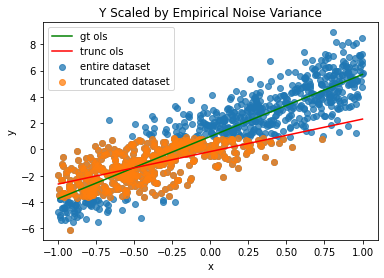

In [5]:
emp_noise_var = (y_trunc - trunc_ols_pred).var(0)
print("emp noise var: ", emp_noise_var)

emp_stand_intervals = [(int_[0]/emp_noise_var, int_[1]/emp_noise_var) for int_ in intervals]
emp_scaled_kinterval = oracle.KIntervalUnion(emp_stand_intervals)

emp_stand_y_trunc = y_trunc / ch.sqrt(emp_noise_var)
trunc_noise_var = (emp_stand_y_trunc - (trunc_ols_pred / ch.sqrt(emp_noise_var))).var(0)
print("trunc reg noise var: ", trunc_noise_var)

new_X, emp_stand_noised = X / beta, noised / ch.sqrt(emp_noise_var)

gt_emp_stand = LinearRegression()
gt_emp_stand.fit(new_X, emp_stand_noised)

trunc_emp_stand_ols = LinearRegression()
trunc_emp_stand_ols.fit(x_trunc_norm, emp_stand_y_trunc)

ax = plt.subplot(1, 1, 1)
plt.scatter(new_X, emp_stand_noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc_norm, emp_stand_y_trunc, label='truncated dataset', alpha=.75)
plt.plot(norm_data, gt_emp_stand.predict(norm_data), color='green', label='gt ols')
plt.plot(norm_data, trunc_emp_stand_ols.predict(norm_data), color='red', label='trunc ols')
plt.legend()
plt.title('Y Scaled by Empirical Noise Variance')
ax.set_xlabel("x")
ax.set_ylabel("y")

First, we will standardize our data for the case where we assume that wee know the underlying ground-truth noise variance.

trunc reg noise var:  tensor([0.5779])
reg noise var:  tensor([1.0810])


Text(0, 0.5, 'y')

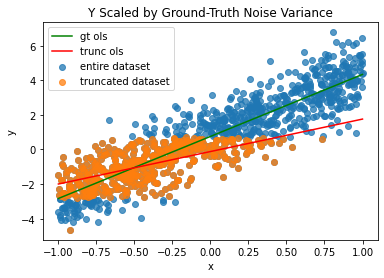

In [6]:
stand_noised, stand_y_trunc = noised / ch.sqrt(noise_var), y_trunc / ch.sqrt(noise_var)
stand_intervals = [(int_[0]/float(ch.sqrt(noise_var)), int_[1]/float(ch.sqrt(noise_var))) for int_ in intervals]
scaled_kinterval = oracle.KIntervalUnion(stand_intervals)

gt_stand = LinearRegression()
gt_stand.fit(new_X, stand_noised)

trunc_stand_ols = LinearRegression()
trunc_stand_ols.fit(x_trunc_norm, stand_y_trunc)

trunc_noise_var = (stand_y_trunc - trunc_stand_ols.predict(x_trunc_norm)).var(0)
print("trunc reg noise var: ", trunc_noise_var)

reg_noise_var = (stand_noised - gt_stand.predict(new_X)).var(0)
print("reg noise var: ", reg_noise_var)

ax = plt.subplot(1, 1, 1)
plt.scatter(new_X, stand_noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc_norm, stand_y_trunc, label='truncated dataset', alpha=.75)
plt.plot(norm_data, gt_stand.predict(norm_data), color='green', label='gt ols')
plt.plot(norm_data, trunc_stand_ols.predict(norm_data), color='red', label='trunc ols')
plt.legend()
plt.title("Y Scaled by Ground-Truth Noise Variance")
ax.set_xlabel("x")
ax.set_ylabel("y")

Truncated Regression with Known Empirical Variance

In [7]:
known_emp_trunc_reg = TruncatedRegression(phi=emp_scaled_kinterval, alpha=alpha, bias=True, unknown=False, val=100, bs=10, n=100, tol=1e-2)
known_emp_trunc_reg.fit(x_trunc_norm, emp_stand_y_trunc)
known_emp_w_unnorm = (known_emp_trunc_reg.weight * ch.sqrt(emp_noise_var)) / beta

known_emp_bias_unnorm = ch.zeros(1, 1)
if args.bias: 
    known_emp_bias_unnorm = (known_emp_trunc_reg.intercept * ch.sqrt(emp_noise_var))

/home/gridsan/stefanou/.local/lib/python3.8/site-packages/torch/autograd/__init__.py:202: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return Variable._execution_engine.run_backward(


Iteration: 0.0 | Score: [0.005334249697625637]
Iteration: 1.0 | Score: [0.023505819961428642]
Iteration: 2.0 | Score: [0.05725365877151489]
Iteration: 3.0 | Score: [0.07684817910194397]
Iteration: 4.0 | Score: [-0.06513912975788116]
Iteration: 5.0 | Score: [0.008842214941978455]


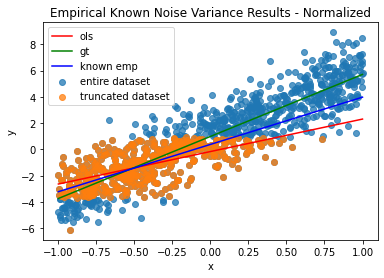

Text(0, 0.5, 'y')

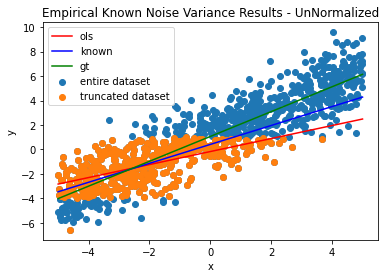

In [8]:
ax = plt.subplot(1, 1, 1)
plt.scatter(new_X, emp_stand_noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc_norm, emp_stand_y_trunc, label='truncated dataset', alpha=.75)
plt.plot(norm_data, trunc_emp_stand_ols.predict(norm_data), color='r', label='ols')
plt.plot(norm_data, gt_emp_stand.predict(norm_data), color='green', label='gt')
plt.plot(norm_data, known_emp_trunc_reg(Tensor(norm_data)).detach().numpy(), label='known emp', color='blue')
plt.legend()
plt.title("Empirical Known Noise Variance Results - Normalized")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

ax = plt.subplot(1, 1, 1)
plt.plot(unnorm_data, trunc_ols.predict(unnorm_data), color='red', label='ols')
plt.plot(unnorm_data, (Tensor(unnorm_data)@known_emp_w_unnorm + known_emp_bias_unnorm).detach().numpy(), label='known', color='blue')
plt.plot(unnorm_data, gt_ols.predict(unnorm_data), color='green', label='gt')
plt.scatter(X, noised, label='entire dataset')
plt.scatter(x_trunc, y_trunc, label='truncated dataset')
plt.legend()
plt.title("Empirical Known Noise Variance Results - UnNormalized")
ax.set_xlabel("x")
ax.set_ylabel("y")

Truncated Regression with Known Variance

In [62]:
known_trunc_reg = TruncatedRegression(phi=scaled_kinterval, alpha=alpha, bias=args.bias, unknown=False, val=100, bs=10, n=100, tol=1e-2, steps=2500)
known_trunc_reg.fit(x_trunc_norm, stand_y_trunc)
known_weight_unnorm = (known_trunc_reg.weight * ch.sqrt(noise_var)) / beta

known_bias_unnorm = ch.zeros(1, 1)
if args.bias:  
    known_bias_unnorm = known_trunc_reg.intercept * ch.sqrt(noise_var)

Iteration: 0.0 | Score: [-0.05916885286569595]
Iteration: 1.0 | Score: [0.04893818125128746]
Iteration: 2.0 | Score: [0.04145364463329315]
Iteration: 3.0 | Score: [0.05550083518028259]
Iteration: 4.0 | Score: [0.07267409563064575]
Iteration: 5.0 | Score: [0.06594416499137878]
Iteration: 6.0 | Score: [0.08675671368837357]
Iteration: 7.0 | Score: [0.07263945788145065]
Iteration: 8.0 | Score: [0.057985685765743256]
Iteration: 9.0 | Score: [0.06590069085359573]
Iteration: 10.0 | Score: [0.07685801386833191]
Iteration: 11.0 | Score: [0.07213655859231949]
Iteration: 12.0 | Score: [0.07778497040271759]
Iteration: 13.0 | Score: [0.0670495480298996]
Iteration: 14.0 | Score: [0.06817517429590225]
Iteration: 15.0 | Score: [0.06831635534763336]
Iteration: 16.0 | Score: [0.050778184086084366]
Iteration: 17.0 | Score: [0.07881157845258713]
Iteration: 18.0 | Score: [0.08631207048892975]
Iteration: 19.0 | Score: [0.0783863216638565]
Iteration: 20.0 | Score: [0.06319235265254974]
Iteration: 21.0 | Scor

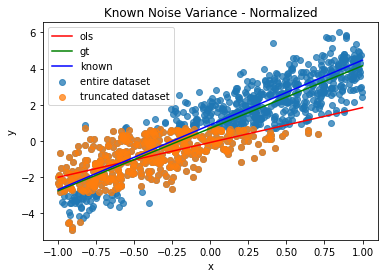

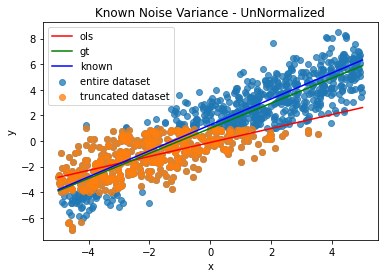

In [63]:
ax = plt.subplot(1, 1, 1)
plt.scatter(new_X, stand_noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc_norm, stand_y_trunc, label='truncated dataset', alpha=.75)
plt.plot(norm_data, trunc_stand_ols.predict(norm_data), color='r', label='ols')
plt.plot(norm_data, gt_stand.predict(norm_data), color='green', label='gt')
plt.plot(norm_data, known_trunc_reg(Tensor(norm_data)).detach().numpy(), label='known', color='blue')
plt.legend()
plt.title("Known Noise Variance - Normalized")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

ax = plt.subplot(1, 1, 1)
plt.scatter(X, noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc, y_trunc, label='truncated dataset', alpha=.75)
plt.plot(unnorm_data, trunc_ols.predict(unnorm_data), color='r', label='ols')
plt.plot(unnorm_data, gt_ols.predict(unnorm_data), color='green', label='gt')
plt.plot(unnorm_data, (Tensor(unnorm_data)@known_weight_unnorm + known_bias_unnorm).detach().numpy(), label='known', color='blue')
plt.legend()
plt.title("Known Noise Variance - UnNormalized")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

Truncated Regression with Unknown Noise Variance

In [64]:
unknown_trunc_reg = TruncatedRegression(phi=emp_scaled_kinterval, alpha=alpha, bias=True, unknown=True, bs=10, n=100, tol=1e-1, val=50, steps=3000)
unknown_trunc_reg.fit(x_trunc_norm, emp_stand_y_trunc)
with ch.no_grad():
    unknown_weight_unnorm = (((unknown_trunc_reg.weight * unknown_trunc_reg.variance) * ch.sqrt(emp_noise_var)) / beta)
    if args.bias: 
        unknown_bias_unnorm = ((unknown_trunc_reg.bias * unknown_trunc_reg.variance) * ch.sqrt(emp_noise_var))

Iteration: 0.0 | Score: [-0.047379814088344574, 0.1375025361776352]
Iteration: 1.0 | Score: [-0.02089824341237545, -0.180572971701622]
Iteration: 2.0 | Score: [0.10863552987575531, 0.06415006518363953]
Iteration: 3.0 | Score: [0.06737342476844788, 0.02363922819495201]


In [39]:
unknown_trunc_reg.weight, gt_emp_stand.coef_

(tensor([[3.0235]], grad_fn=<PermuteBackward>),
 array([[4.193836]], dtype=float32))

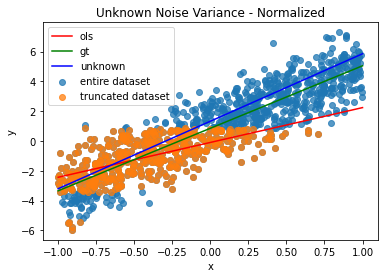

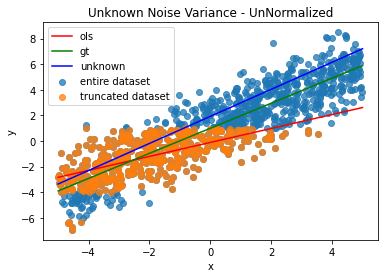

In [65]:
ax = plt.subplot(1, 1, 1)
plt.scatter(new_X, emp_stand_noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc_norm, emp_stand_y_trunc, label='truncated dataset', alpha=.75)
plt.plot(norm_data, trunc_emp_stand_ols.predict(norm_data), color='r', label='ols')
plt.plot(norm_data, gt_emp_stand.predict(norm_data), color='green', label='gt')
plt.plot(norm_data, unknown_trunc_reg(Tensor(norm_data)).detach().numpy(), label='unknown', color='blue')
plt.legend()
ax.set_title("Unknown Noise Variance - Normalized")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

ax = plt.subplot(1, 1, 1)
plt.scatter(X, noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc, y_trunc, label='truncated dataset', alpha=.75)
plt.plot(unnorm_data, trunc_ols.predict(unnorm_data), label='ols', color='red')
plt.plot(unnorm_data, gt_ols.predict(unnorm_data), color='g', label='gt')
plt.plot(unnorm_data, (Tensor(unnorm_data)@unknown_weight_unnorm + unknown_bias_unnorm), color='blue', label='unknown')
plt.legend()
ax.set_title("Unknown Noise Variance - UnNormalized")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

# Truncate at Zero and Run for High Variance

In [122]:
args.__setattr__('bs', 10)
args.__setattr__('steps', 2500)
args.__setattr__('step_lr', 100)
args.__setattr__('step_lr_gamma', .9)
args.__setattr__('tol', 1e-2)
args.__setattr__('trials', 20)
args.__setattr__('n', 100)


EXP = '4Intervals3Trials'

In [123]:
def run_trial(kwargs, X, y):
    """
    Runs a trial of a truncated regression experiment. Runs a maximum 
    of three trials of an experiment. The experiment terminates when either 
    the norm of teh score is less than 3e-1, or when three trials is up. After 
    three trials it returns the best truncated regression experiment.
    :param kwargs: keyword arguments for experiment 
    :param X: independent variable
    :param y: dependent variable
    :return: truncated regression experiment and time that experiment took
    """
    st = datetime.datetime.now()        
    # run procedure until get reasonable score
    attempt, score, best_trunc_reg = 0, None, None
    while (score is None or score.norm() > 3e-1) and attempt < 3:
        trunc_reg = TruncatedRegression(**kwargs)
        trunc_reg.fit(X, y)
        grad = trunc_reg.score()
        if score is None or grad.norm() < score.norm(): 
            score, best_trunc_reg = grad, trunc_reg
        attempt += 1
    total_time = int((datetime.datetime.now() - st).total_seconds())
    return best_trunc_reg, total_time  

In [124]:
 # expriment parameters
w_lower, w_upper = -1, 1
d, k = 2, 1

# distribution for generating feature vectors
dist = MultivariateNormal(ch.zeros(d), ch.eye(d)/d)
dist = Uniform(-10, 10)
samples = [100, 125, 150, 175, 200, 225, 250, 275, 300, 400, 500, 750, 1000, 1500, 2000, 2500]
intervals = [(-20, -5), (-3, 0), (8, 10)]
phi = oracle.KIntervalUnion(intervals)
noise_var = Tensor([10.0])

stand_intervals = [(int_[0]/float(ch.sqrt(noise_var)), int_[1]/float(ch.sqrt(noise_var))) for int_ in intervals]
scaled_kinterval = oracle.KIntervalUnion(stand_intervals)

# generate ground truth
gt = ch.nn.Linear(in_features=d, out_features=k)
gt.weight = ch.nn.Parameter(ch.ones(k, d))
gt.bias = ch.nn.Parameter(ch.ones(1, 1)) if args.bias else None

for i in range(args.trials):
    # create store and add table
    store = Store(OUT_DIR + EXP)
    store.add_table(TABLE_NAME, { 
        'ols_r2': float,
        'ols_param_mse': float,
        'ols_var_l1': float,
        'known_r2': float,
        'known_param_mse': float,
        'known_time': int,
        'unknown_r2': float, 
        'unknown_param_mse': float,
        'unknown_var_l1': float,
        'unknown_time': int,
        'alpha': float, 
        'num_samples': int,
        'noise_var': float, 
    })
    
    
    for s in samples: 
        X, noised = Tensor([]), Tensor([])
        x_trunc, y_trunc = Tensor([]), Tensor([])
        
        # generate data until s number of samples fall within the truncation set
        with ch.no_grad():
            while x_trunc.size(0) < s: 
                x_ = dist.sample(ch.Size([s, d])) if isinstance(dist, Uniform) else dist.sample(ch.Size([s]))
                new_noised = gt(x_) + ch.sqrt(noise_var) * ch.randn(s, 1)
                # add noise to ground-truth pedictions
                # truncate based off of the standardized data
                indices = phi(new_noised).flatten().nonzero(as_tuple=False).flatten()
                y_trunc, x_trunc = ch.cat([y_trunc, new_noised[indices]]), ch.cat([x_trunc, x_[indices]])
                X, noised = ch.cat([X, x_]), ch.cat([noised, new_noised])
        x_trunc, y_trunc = x_trunc[:s], y_trunc[:s]
        alpha = Tensor([y_trunc.size(0) / noised.size(0)])
        print("alpha: ", alpha)
        val = int(.2*s)
        
        # normalize x features so that ||x_{i}||_{2}^{2} <= 1
        l_inf = LA.norm(x_trunc, dim=-1, ord=float('inf')).max() # find max l_inf
        # calculate normalizing constant
        beta = l_inf*math.sqrt(d)
        """
        Divide input features by normalizing constant. By doing so, 
        the weights will be increased by a magnitude of beta.
        """
        x_trunc_norm = x_trunc / beta
         # normalize entire dataset by beta
        x_norm = X / beta
        
        # ground-truth ols
        gt_ols = LinearRegression()
        gt_ols.fit(X, noised)
        gt_params = ch.cat([Tensor(gt_ols.coef_).T, Tensor(gt_ols.intercept_)[..., None]]).flatten()
        
        # empirical linear regression
        ols = LinearRegression() 
        ols.fit(x_trunc, y_trunc)
        ols_var = ch.var(Tensor(ols.predict(x_trunc)) - y_trunc, dim=0)[..., None]
        ols_params = ch.cat([Tensor(ols.coef_).T, Tensor(ols.intercept_)[..., None]]).flatten()
        # check r2 for entire dataset
        ols_pred = ols.predict(X)

        # ols results
        store[TABLE_NAME].update_row({
            'ols_r2': r2_score(noised.flatten(), ols_pred.flatten()), 
            'ols_var_l1': ch.abs(ols_var - noise_var),
            'ols_param_mse': mse_loss(ols_params, gt_params),
        })
        
        """
        Run dataset on truncated regression with known variance, while 
        assuming that the empirical noise variance is the underlying noise 
        variance of our linear regression. This means that we want to standardize 
        our dependent variable by the empirical noise variance. 
        """
        # variance of the residuals
        emp_noise_var = (y_trunc - ols.predict(x_trunc_norm)).var(0)
        emp_stand_intervals = [(int_[0]/math.sqrt(float(emp_noise_var)), int_[1]/math.sqrt(float(emp_noise_var))) for int_ in intervals]
        emp_scaled_kinterval = oracle.KIntervalUnion(emp_stand_intervals)
        # standardize y trunc by the empirical noise variance
        emp_stand_y_trunc = y_trunc / ch.sqrt(emp_noise_var)        
        
        """
        Run dataset on truncated regression with known variance. This means that we want to standardize 
        our dependent variable by the true noise variance. 
        """
        # standardize y trunc by actual noise variance
        stand_y_trunc = y_trunc / ch.sqrt(noise_var)
        # standardize noised by actual noise variance
        known_kwargs = { 
            'phi': scaled_kinterval, 
            'alpha': alpha, 
            'bias': args.bias, 
            'unknown': False, 
            'bs': args.bs, 
            'n': args.n, 
            'tol': args.tol, 
            'steps': args.steps, 
            'val': val
        }
        known_trunc_reg, total_time = run_trial(known_kwargs, x_trunc_norm, stand_y_trunc)

        with ch.no_grad():
            w, w0 = (known_trunc_reg.weight * ch.sqrt(noise_var)) / beta, known_trunc_reg.intercept[..., None] * ch.sqrt(noise_var)
            known_params = ch.cat([w, w0]).flatten()
            # known results
            store[TABLE_NAME].update_row({
                'known_r2': r2_score(noised.flatten(), X@w + w0), 
                'known_param_mse': mse_loss(known_params, gt_params),
                'known_time': total_time, 
            })
        
        # truncated regression with unknown variance
            
        unknown_kwargs = { 
            'phi': emp_scaled_kinterval, 
            'alpha': alpha, 
            'bias': args.bias, 
            'unknown': True, 
            'bs': args.bs, 
            'n': args.n, 
            'tol': args.tol, 
            'steps': args.steps, 
            'val': val
        }
        unknown_trunc_reg, total_time = run_trial(unknown_kwargs, x_trunc_norm, emp_stand_y_trunc)
    
        with ch.no_grad():
            unknown_var = unknown_trunc_reg.variance * emp_noise_var
            w, w0 = (((unknown_trunc_reg.weight * unknown_trunc_reg.variance) * ch.sqrt(emp_noise_var)) / beta).detach(), ((unknown_trunc_reg.intercept * ch.sqrt(emp_noise_var)))[None,...]
            unknown_params = ch.cat([w, w0]).flatten()

            # known emp results
            store[TABLE_NAME].update_row({
                'unknown_r2': r2_score(noised.flatten(), X@w + w0), 
                'unknown_param_mse': mse_loss(unknown_params, gt_params),
                'unknown_var_l1': float(ch.abs(unknown_var - noise_var)),
                'unknown_time': total_time, 
            })
        
        
        # add additional exp data to store
        store[TABLE_NAME].update_row({ 
            'alpha': float(alpha.flatten()),
            'num_samples': x_trunc.size(0),
            'noise_var': noise_var, 
        })

        # append row to table
        store[TABLE_NAME].flush_row()
    store.close()    

Logging in: /home/gridsan/stefanou/Regression/4Intervals3Trials/124e4382-ac1a-41e0-b6a6-6ced996019c8
alpha:  tensor([0.3333])
Iteration: 0.0 | Score: [0.027479618787765503]
Iteration: 1.0 | Score: [0.2184583842754364]
Iteration: 2.0 | Score: [0.1701899766921997]
Iteration: 3.0 | Score: [0.22368064522743225]
Iteration: 4.0 | Score: [0.22556915879249573]
Iteration: 5.0 | Score: [0.22306707501411438]
Iteration: 6.0 | Score: [0.18048253655433655]
Iteration: 7.0 | Score: [0.20092815160751343]
Iteration: 8.0 | Score: [0.21329593658447266]
Iteration: 9.0 | Score: [0.2048320174217224]
Iteration: 10.0 | Score: [0.22775821387767792]
Iteration: 11.0 | Score: [0.158890962600708]
Iteration: 12.0 | Score: [0.23181727528572083]
Iteration: 13.0 | Score: [0.2352595031261444]
Iteration: 14.0 | Score: [0.25110912322998047]
Iteration: 15.0 | Score: [0.2298162579536438]
Iteration: 16.0 | Score: [0.1586790680885315]
Iteration: 17.0 | Score: [0.20130819082260132]
Iteration: 18.0 | Score: [0.21601682901382446

Iteration: 10.0 | Score: [0.09083402901887894, -0.02912771888077259]
Iteration: 11.0 | Score: [0.08650502562522888, -0.02323089726269245]
Iteration: 12.0 | Score: [0.11821875721216202, -0.028976624831557274]
Iteration: 13.0 | Score: [0.09609770029783249, -0.04622182622551918]
Iteration: 14.0 | Score: [0.08681860566139221, -0.01845797896385193]
Iteration: 15.0 | Score: [0.09748639166355133, -0.030528895556926727]
Iteration: 16.0 | Score: [0.0821726992726326, -0.031733959913253784]
Iteration: 17.0 | Score: [0.1051795706152916, -0.025446536019444466]
Iteration: 18.0 | Score: [0.08444667607545853, -0.031389933079481125]
Iteration: 19.0 | Score: [0.07524434477090836, -0.034043408930301666]
Iteration: 20.0 | Score: [0.08442272990942001, -0.03199511766433716]
Iteration: 21.0 | Score: [0.09915249794721603, -0.03368501737713814]
Iteration: 22.0 | Score: [0.07847557216882706, -0.05138643458485603]
Iteration: 23.0 | Score: [0.10184464603662491, -0.026905221864581108]
Iteration: 24.0 | Score: [0.0

Iteration: 1.0 | Score: [-0.01427501067519188, 0.07477664202451706]
Iteration: 2.0 | Score: [0.004010998643934727, 0.07088509947061539]
Iteration: 3.0 | Score: [0.015209398232400417, 0.037458501756191254]
Iteration: 4.0 | Score: [0.014695403166115284, 0.0643923208117485]
Iteration: 5.0 | Score: [0.011725845746695995, 0.04552745074033737]
Iteration: 6.0 | Score: [0.017826024442911148, 0.062277331948280334]
Iteration: 7.0 | Score: [0.004536001477390528, 0.05024324730038643]
Iteration: 8.0 | Score: [0.013372150249779224, 0.07377462089061737]
Iteration: 9.0 | Score: [0.015535131096839905, 0.03681730479001999]
Iteration: 10.0 | Score: [0.021995389834046364, 0.05527922511100769]
Iteration: 11.0 | Score: [0.024170948192477226, 0.0811825841665268]
Iteration: 12.0 | Score: [-0.006020932924002409, 0.050472378730773926]
Iteration: 13.0 | Score: [0.006740108132362366, 0.083948515355587]
Iteration: 14.0 | Score: [0.0072336941957473755, 0.06329995393753052]
Iteration: 15.0 | Score: [0.01321396883577

Iteration: 20.0 | Score: [0.09086538851261139]
Iteration: 21.0 | Score: [0.04636610299348831]
Iteration: 22.0 | Score: [0.06951960921287537]
Iteration: 23.0 | Score: [0.0430140420794487]
Iteration: 24.0 | Score: [0.07459726184606552]
Iteration: 25.0 | Score: [0.05401799827814102]
Iteration: 0.0 | Score: [-0.06323322653770447, -0.042013924568891525]
Iteration: 1.0 | Score: [-0.02846495807170868, -0.030590137466788292]
Iteration: 2.0 | Score: [-0.006648207549005747, 0.00036498159170150757]
alpha:  tensor([0.3333])
Iteration: 0.0 | Score: [-0.08419300615787506]
Iteration: 1.0 | Score: [0.028155596926808357]
Iteration: 2.0 | Score: [0.14887113869190216]
Iteration: 3.0 | Score: [0.048969365656375885]
Iteration: 4.0 | Score: [0.14335334300994873]
Iteration: 5.0 | Score: [0.05549727752804756]
Iteration: 6.0 | Score: [0.11023740470409393]
Iteration: 7.0 | Score: [0.05800454691052437]
Iteration: 8.0 | Score: [0.1271149218082428]
Iteration: 9.0 | Score: [0.0510924756526947]
Iteration: 10.0 | Sco

Iteration: 0.0 | Score: [-0.04558567330241203]
Iteration: 1.0 | Score: [0.1698491871356964]
Iteration: 2.0 | Score: [0.057681113481521606]
Iteration: 3.0 | Score: [0.13233621418476105]
Iteration: 4.0 | Score: [0.13636311888694763]
Iteration: 5.0 | Score: [0.20980940759181976]
Iteration: 6.0 | Score: [0.15034815669059753]
Iteration: 7.0 | Score: [0.17033877968788147]
Iteration: 8.0 | Score: [0.11442980915307999]
Iteration: 9.0 | Score: [0.15308040380477905]
Iteration: 10.0 | Score: [0.11542987078428268]
Iteration: 11.0 | Score: [0.1403028517961502]
Iteration: 12.0 | Score: [0.15974588692188263]
Iteration: 13.0 | Score: [0.16514910757541656]
Iteration: 14.0 | Score: [0.1424812525510788]
Iteration: 15.0 | Score: [0.1419956386089325]
Iteration: 16.0 | Score: [0.12990450859069824]
Iteration: 17.0 | Score: [0.15403752028942108]
Iteration: 18.0 | Score: [0.14080333709716797]
Iteration: 19.0 | Score: [0.1461711972951889]
Iteration: 20.0 | Score: [0.15762782096862793]
Iteration: 21.0 | Score: [

Iteration: 2.0 | Score: [-0.06700004637241364, -0.029878847301006317]
Iteration: 3.0 | Score: [-0.04108092188835144, -0.028815001249313354]
Iteration: 4.0 | Score: [-0.07659151405096054, -0.05167084559798241]
Iteration: 5.0 | Score: [-0.049061089754104614, -0.02141401171684265]
Iteration: 6.0 | Score: [-0.0672985315322876, -0.017682045698165894]
Iteration: 7.0 | Score: [-0.06309860944747925, -0.03876455873250961]
Iteration: 8.0 | Score: [-0.043020520359277725, -0.02515460178256035]
Iteration: 9.0 | Score: [-0.0583614744246006, -0.025162354111671448]
Iteration: 10.0 | Score: [-0.06452838331460953, -0.04533163458108902]
Iteration: 11.0 | Score: [-0.030502062290906906, -0.05299091339111328]
Iteration: 12.0 | Score: [-0.036430541425943375, -0.025506868958473206]
Iteration: 13.0 | Score: [-0.045767106115818024, -0.04050970822572708]
Iteration: 14.0 | Score: [-0.03103475086390972, -0.038792937994003296]
Iteration: 15.0 | Score: [-0.06139827147126198, -0.040819816291332245]
Iteration: 16.0 | 

Iteration: 16.0 | Score: [0.1579870879650116]
Iteration: 17.0 | Score: [0.14993952214717865]
Iteration: 18.0 | Score: [0.160919651389122]
Iteration: 19.0 | Score: [0.18462975323200226]
Iteration: 20.0 | Score: [0.19877424836158752]
Iteration: 21.0 | Score: [0.13406535983085632]
Iteration: 22.0 | Score: [0.16738329827785492]
Iteration: 23.0 | Score: [0.15697799623012543]
Iteration: 24.0 | Score: [0.16926774382591248]
Iteration: 25.0 | Score: [0.09984444826841354]
Iteration: 0.0 | Score: [0.0006858003325760365, 0.0519128143787384]
Iteration: 1.0 | Score: [0.07271148264408112, 0.10052502155303955]
Iteration: 2.0 | Score: [0.07121976464986801, 0.07870389521121979]
Iteration: 3.0 | Score: [0.09775370359420776, 0.0564919114112854]
Iteration: 4.0 | Score: [0.0868351086974144, 0.06530251353979111]
Iteration: 5.0 | Score: [0.08681350946426392, 0.06974074244499207]
Iteration: 6.0 | Score: [0.07182452827692032, 0.049157824367284775]
Iteration: 7.0 | Score: [0.09853411465883255, 0.0663869157433509

Iteration: 3.0 | Score: [0.06877213716506958, 0.09630490839481354]
Iteration: 4.0 | Score: [0.07035083323717117, 0.07512660324573517]
Iteration: 5.0 | Score: [0.06334249675273895, 0.09380552917718887]
Iteration: 6.0 | Score: [0.052323613315820694, 0.07711909711360931]
Iteration: 7.0 | Score: [0.0737423449754715, 0.09747903794050217]
Iteration: 8.0 | Score: [0.0708388164639473, 0.08683577179908752]
Iteration: 9.0 | Score: [0.09259580075740814, 0.09852702915668488]
Iteration: 10.0 | Score: [0.05619464069604874, 0.0736352950334549]
Iteration: 11.0 | Score: [0.0646197497844696, 0.09644994139671326]
Iteration: 12.0 | Score: [0.0745796337723732, 0.08748890459537506]
Iteration: 13.0 | Score: [0.0836622342467308, 0.09069779515266418]
Iteration: 14.0 | Score: [0.07928050309419632, 0.1029350757598877]
Iteration: 15.0 | Score: [0.05730745196342468, 0.09757286310195923]
Iteration: 16.0 | Score: [0.06952328234910965, 0.10175289213657379]
Iteration: 17.0 | Score: [0.06932162493467331, 0.087954260408

Iteration: 1.0 | Score: [0.014977275393903255, 0.04439598321914673]
Iteration: 2.0 | Score: [-0.006085868924856186, 0.018774397671222687]
Iteration: 3.0 | Score: [-0.002457510447129607, -0.007598230615258217]
alpha:  tensor([0.3333])
Iteration: 0.0 | Score: [-0.1802649199962616]
Iteration: 1.0 | Score: [0.08563167601823807]
Iteration: 2.0 | Score: [-0.0037951935082674026]
Iteration: 0.0 | Score: [-0.12219905108213425, -0.017216291278600693]
Iteration: 1.0 | Score: [-0.07923151552677155, -0.010920729488134384]
Iteration: 2.0 | Score: [-0.05757097527384758, 0.005986788310110569]
Iteration: 3.0 | Score: [-0.0625181645154953, -0.00636143796145916]
Iteration: 4.0 | Score: [-0.04617207497358322, 0.00408674031496048]
Iteration: 5.0 | Score: [-0.050949230790138245, -0.017812838777899742]
Iteration: 6.0 | Score: [-0.04370961710810661, 0.006920422427356243]
Iteration: 7.0 | Score: [-0.05195131525397301, -0.02204962819814682]
Iteration: 8.0 | Score: [-0.025680558755993843, 0.000446525402367115]
I

Iteration: 18.0 | Score: [0.028593288734555244, 0.03096352145075798]
Iteration: 19.0 | Score: [0.06565931439399719, 0.05464349687099457]
Iteration: 20.0 | Score: [0.031003057956695557, 0.028143800795078278]
Iteration: 21.0 | Score: [0.06721393018960953, 0.0649322122335434]
Iteration: 22.0 | Score: [0.031203415244817734, 0.03266254812479019]
Iteration: 23.0 | Score: [0.03197520226240158, 0.04995274543762207]
Iteration: 24.0 | Score: [0.026581892743706703, 0.04847751930356026]
Iteration: 25.0 | Score: [0.029873134568333626, 0.03432952240109444]
alpha:  tensor([0.3333])
Iteration: 0.0 | Score: [-0.16435331106185913]
Iteration: 1.0 | Score: [0.036599770188331604]
Iteration: 2.0 | Score: [-0.046277351677417755]
Iteration: 3.0 | Score: [-0.06413272768259048]
Iteration: 4.0 | Score: [-0.03677909076213837]
Iteration: 5.0 | Score: [-4.5925378799438477e-05]
Iteration: 0.0 | Score: [0.11822482943534851, 0.22895164787769318]
Iteration: 1.0 | Score: [0.19227159023284912, 0.25118011236190796]
Iterat

Iteration: 21.0 | Score: [-0.10256292670965195, -0.1018359512090683]
Iteration: 22.0 | Score: [-0.09580547362565994, -0.08621975034475327]
Iteration: 23.0 | Score: [-0.09793679416179657, -0.07671964913606644]
Iteration: 24.0 | Score: [-0.09771867841482162, -0.08319718390703201]
Iteration: 25.0 | Score: [-0.11243993788957596, -0.11083602160215378]
alpha:  tensor([0.3333])
Iteration: 0.0 | Score: [-0.39568814635276794]
Iteration: 1.0 | Score: [-0.18813556432724]
Iteration: 2.0 | Score: [-0.1423962563276291]
Iteration: 3.0 | Score: [-0.2090042233467102]
Iteration: 4.0 | Score: [-0.17120128870010376]
Iteration: 5.0 | Score: [-0.15784341096878052]
Iteration: 6.0 | Score: [-0.16421228647232056]
Iteration: 7.0 | Score: [-0.2128220498561859]
Iteration: 8.0 | Score: [-0.1851557493209839]
Iteration: 9.0 | Score: [-0.1577119678258896]
Iteration: 10.0 | Score: [-0.21589946746826172]
Iteration: 11.0 | Score: [-0.1805337816476822]
Iteration: 12.0 | Score: [-0.1801188886165619]
Iteration: 13.0 | Scor

Iteration: 8.0 | Score: [0.002253397135064006, -0.02404094487428665]
Iteration: 9.0 | Score: [0.01603834517300129, -0.011215494945645332]
Iteration: 10.0 | Score: [-0.007597337942570448, -0.024243775755167007]
Iteration: 11.0 | Score: [0.012850301340222359, -0.016456611454486847]
Iteration: 12.0 | Score: [0.011187838390469551, -0.018699271604418755]
Iteration: 13.0 | Score: [0.012673715129494667, -0.018569892272353172]
Iteration: 14.0 | Score: [0.003937557339668274, -0.02136552333831787]
Iteration: 15.0 | Score: [0.003197841113433242, -0.015647633001208305]
Iteration: 16.0 | Score: [0.012564735487103462, -0.016238179057836533]
Iteration: 17.0 | Score: [0.009486479684710503, -0.023048343136906624]
Iteration: 18.0 | Score: [0.011928786523640156, -0.01996542513370514]
Iteration: 19.0 | Score: [0.01430757436901331, -0.006437479518353939]
Iteration: 20.0 | Score: [0.0012785918079316616, -0.026378799229860306]
Iteration: 21.0 | Score: [0.022437410429120064, -0.008955012075603008]
Iteration: 

Iteration: 8.0 | Score: [0.05137840658426285, 0.06011832132935524]
Iteration: 9.0 | Score: [0.034111376851797104, 0.05631455034017563]
Iteration: 10.0 | Score: [0.04552513360977173, 0.06116537004709244]
Iteration: 11.0 | Score: [0.029436608776450157, 0.046704284846782684]
Iteration: 12.0 | Score: [0.029610486701130867, 0.06714150309562683]
Iteration: 13.0 | Score: [0.03901146724820137, 0.06801655888557434]
Iteration: 14.0 | Score: [0.029455920681357384, 0.05542420595884323]
Iteration: 15.0 | Score: [0.03506999835371971, 0.057048499584198]
Iteration: 16.0 | Score: [0.041096895933151245, 0.07389611005783081]
Iteration: 17.0 | Score: [0.04043259099125862, 0.06763703376054764]
Iteration: 18.0 | Score: [0.030905263498425484, 0.05145477503538132]
Iteration: 19.0 | Score: [0.02361476793885231, 0.07533352822065353]
Iteration: 20.0 | Score: [0.040799278765916824, 0.04933387413620949]
Iteration: 21.0 | Score: [0.034460801631212234, 0.06364155560731888]
Iteration: 22.0 | Score: [0.028927735984325

Iteration: 1.0 | Score: [-0.044992562383413315]
Iteration: 2.0 | Score: [-0.03140280395746231]
Iteration: 3.0 | Score: [0.05455629527568817]
Iteration: 4.0 | Score: [0.0036453977227211]
Iteration: 0.0 | Score: [-0.09962063282728195, -0.0267503522336483]
Iteration: 1.0 | Score: [-0.03767452761530876, 0.006131000816822052]
Iteration: 2.0 | Score: [-0.006096044555306435, 0.034504666924476624]
Iteration: 3.0 | Score: [-0.027340512722730637, 0.002498304471373558]
Iteration: 4.0 | Score: [-0.022060899063944817, -0.006122629623860121]
Iteration: 5.0 | Score: [-0.029375214129686356, -0.004953536670655012]
Iteration: 6.0 | Score: [-0.006782177370041609, 0.025880441069602966]
Iteration: 7.0 | Score: [-0.013538377359509468, 0.006789373233914375]
Iteration: 8.0 | Score: [-0.02656501904129982, 0.003255657386034727]
Iteration: 9.0 | Score: [-0.021070966497063637, -0.001346783246845007]
Iteration: 10.0 | Score: [-0.020113790407776833, 0.014044467359781265]
Iteration: 11.0 | Score: [-0.019620014354586

Iteration: 22.0 | Score: [-0.01989312469959259, -0.14308284223079681]
Iteration: 23.0 | Score: [-0.028336526826024055, -0.1561373919248581]
Iteration: 24.0 | Score: [-0.020370159298181534, -0.1509229987859726]
Iteration: 25.0 | Score: [-0.0319749191403389, -0.18936468660831451]
alpha:  tensor([0.3333])
Iteration: 0.0 | Score: [0.05091343820095062]
Iteration: 1.0 | Score: [0.16647830605506897]
Iteration: 2.0 | Score: [0.22800032794475555]
Iteration: 3.0 | Score: [0.142045795917511]
Iteration: 4.0 | Score: [0.1494443118572235]
Iteration: 5.0 | Score: [0.13295632600784302]
Iteration: 6.0 | Score: [0.17247405648231506]
Iteration: 7.0 | Score: [0.13394799828529358]
Iteration: 8.0 | Score: [0.16317987442016602]
Iteration: 9.0 | Score: [0.1875094771385193]
Iteration: 10.0 | Score: [0.18427994847297668]
Iteration: 11.0 | Score: [0.15366023778915405]
Iteration: 12.0 | Score: [0.13358177244663239]
Iteration: 13.0 | Score: [0.1532413512468338]
Iteration: 14.0 | Score: [0.12165826559066772]
Iterat

Iteration: 17.0 | Score: [0.09891358762979507]
Iteration: 18.0 | Score: [0.12564785778522491]
Iteration: 19.0 | Score: [0.11707499623298645]
Iteration: 20.0 | Score: [0.0890878438949585]
Iteration: 21.0 | Score: [0.11301752179861069]
Iteration: 22.0 | Score: [0.11942809075117111]
Iteration: 23.0 | Score: [0.1192498654127121]
Iteration: 24.0 | Score: [0.10009703040122986]
Iteration: 25.0 | Score: [0.10428591817617416]
Iteration: 0.0 | Score: [-0.06064721569418907, -0.06222768872976303]
Iteration: 1.0 | Score: [0.006744868587702513, -0.01747247576713562]
Iteration: 2.0 | Score: [0.014384484849870205, -0.004768971353769302]
Iteration: 3.0 | Score: [0.03520083799958229, -0.005136402323842049]
Iteration: 4.0 | Score: [0.016376541927456856, -0.023347126320004463]
Iteration: 5.0 | Score: [0.006869942415505648, -0.024824436753988266]
Iteration: 6.0 | Score: [0.023459501564502716, -0.04395461454987526]
Iteration: 7.0 | Score: [0.019232628867030144, -0.01340646855533123]
Iteration: 8.0 | Score: 

Iteration: 25.0 | Score: [-0.0345965176820755, -0.03829053044319153]
alpha:  tensor([0.3333])
Iteration: 0.0 | Score: [-0.27425312995910645]
Iteration: 1.0 | Score: [-0.08658032864332199]
Iteration: 2.0 | Score: [-0.13668662309646606]
Iteration: 3.0 | Score: [-0.07560582458972931]
Iteration: 4.0 | Score: [-0.16104112565517426]
Iteration: 5.0 | Score: [-0.11028316617012024]
Iteration: 6.0 | Score: [-0.09176381677389145]
Iteration: 7.0 | Score: [-0.13769632577896118]
Iteration: 8.0 | Score: [-0.08678960055112839]
Iteration: 9.0 | Score: [-0.12628556787967682]
Iteration: 10.0 | Score: [-0.11010654270648956]
Iteration: 11.0 | Score: [-0.17651227116584778]
Iteration: 12.0 | Score: [-0.0938040018081665]
Iteration: 13.0 | Score: [-0.1298876404762268]
Iteration: 14.0 | Score: [-0.12090465426445007]
Iteration: 15.0 | Score: [-0.12997883558273315]
Iteration: 16.0 | Score: [-0.1337195783853531]
Iteration: 17.0 | Score: [-0.11871570348739624]
Iteration: 18.0 | Score: [-0.12906692922115326]
Iterati

Iteration: 11.0 | Score: [-0.06529740989208221, -0.03042883425951004]
Iteration: 12.0 | Score: [-0.07386317104101181, -0.03403325751423836]
Iteration: 13.0 | Score: [-0.06274667382240295, -0.034402862191200256]
Iteration: 14.0 | Score: [-0.07063358277082443, -0.0385286882519722]
Iteration: 15.0 | Score: [-0.07039482891559601, -0.033137060701847076]
Iteration: 16.0 | Score: [-0.07590867578983307, -0.027972646057605743]
Iteration: 17.0 | Score: [-0.06780516356229782, -0.026785431429743767]
Iteration: 18.0 | Score: [-0.08017382025718689, -0.03262244537472725]
Iteration: 19.0 | Score: [-0.06967718154191971, -0.022858187556266785]
Iteration: 20.0 | Score: [-0.06113163381814957, -0.03117435798048973]
Iteration: 21.0 | Score: [-0.07141144573688507, -0.02492951601743698]
Iteration: 22.0 | Score: [-0.07074282318353653, -0.04467293620109558]
Iteration: 23.0 | Score: [-0.07174096256494522, -0.0342789888381958]
Iteration: 24.0 | Score: [-0.06645649671554565, -0.033013902604579926]
Iteration: 25.0 

Iteration: 16.0 | Score: [-0.027741586789488792, -0.01793113723397255]
Iteration: 17.0 | Score: [-0.02815045788884163, -0.020412854850292206]
Iteration: 18.0 | Score: [-0.031763263046741486, -0.020782191306352615]
Iteration: 19.0 | Score: [-0.02592538855969906, -0.013639614917337894]
Iteration: 20.0 | Score: [-0.02611812762916088, -0.02116609923541546]
Iteration: 21.0 | Score: [-0.023859811946749687, -0.013885731808841228]
Iteration: 22.0 | Score: [-0.023733973503112793, -0.018299926072359085]
Iteration: 23.0 | Score: [-0.03348663076758385, -0.01869148761034012]
Iteration: 24.0 | Score: [-0.024862157180905342, -0.01702365092933178]
Iteration: 25.0 | Score: [-0.025728914886713028, -0.01961568556725979]
alpha:  tensor([0.3333])
Iteration: 0.0 | Score: [-0.16398891806602478]
Iteration: 1.0 | Score: [0.015894850715994835]
Iteration: 2.0 | Score: [0.13701754808425903]
Iteration: 3.0 | Score: [0.01768004149198532]
Iteration: 4.0 | Score: [0.1405450999736786]
Iteration: 5.0 | Score: [0.041679

Iteration: 7.0 | Score: [0.0024245649110525846, 0.014938972890377045]
Iteration: 8.0 | Score: [-0.032478999346494675, -0.002168964594602585]
Iteration: 9.0 | Score: [-0.006875072605907917, 0.001981973648071289]
alpha:  tensor([0.3333])
Iteration: 0.0 | Score: [0.0808132141828537]
Iteration: 1.0 | Score: [0.37589532136917114]
Iteration: 2.0 | Score: [0.3469937741756439]
Iteration: 3.0 | Score: [0.36130034923553467]
Iteration: 4.0 | Score: [0.3829590976238251]
Iteration: 5.0 | Score: [0.3550478518009186]
Iteration: 6.0 | Score: [0.3841703236103058]
Iteration: 7.0 | Score: [0.3712747097015381]
Iteration: 8.0 | Score: [0.3595772683620453]
Iteration: 9.0 | Score: [0.32143813371658325]
Iteration: 10.0 | Score: [0.3253609240055084]
Iteration: 11.0 | Score: [0.3698130249977112]
Iteration: 12.0 | Score: [0.3732259273529053]
Iteration: 13.0 | Score: [0.39407581090927124]
Iteration: 14.0 | Score: [0.39097973704338074]
Iteration: 15.0 | Score: [0.3264465928077698]
Iteration: 16.0 | Score: [0.37046

Iteration: 16.0 | Score: [-0.16285155713558197]
Iteration: 17.0 | Score: [-0.1148928701877594]
Iteration: 18.0 | Score: [-0.10313207656145096]
Iteration: 19.0 | Score: [-0.11756829172372818]
Iteration: 20.0 | Score: [-0.14569328725337982]
Iteration: 21.0 | Score: [-0.16231131553649902]
Iteration: 22.0 | Score: [-0.1538413017988205]
Iteration: 23.0 | Score: [-0.12016767263412476]
Iteration: 24.0 | Score: [-0.1197831779718399]
Iteration: 25.0 | Score: [-0.1562173068523407]
Iteration: 0.0 | Score: [-0.06657722592353821, -0.06649994105100632]
Iteration: 1.0 | Score: [0.009655434638261795, -0.020470518618822098]
Iteration: 2.0 | Score: [0.01915188692510128, -0.04436798766255379]
Iteration: 3.0 | Score: [0.03150014579296112, -0.033154308795928955]
Iteration: 4.0 | Score: [0.025985533371567726, -0.054560866206884384]
Iteration: 5.0 | Score: [0.044589050114154816, -0.05724944546818733]
Iteration: 6.0 | Score: [0.03387470915913582, -0.04677058011293411]
Iteration: 7.0 | Score: [0.03302333876490

Iteration: 24.0 | Score: [-0.03612411394715309, 0.05393906682729721]
Iteration: 25.0 | Score: [-0.033644236624240875, 0.06281524151563644]
alpha:  tensor([0.3333])
Iteration: 0.0 | Score: [-0.2591531574726105]
Iteration: 1.0 | Score: [-0.15328381955623627]
Iteration: 2.0 | Score: [-0.11550641804933548]
Iteration: 3.0 | Score: [-0.03753708675503731]
Iteration: 4.0 | Score: [-0.013139558956027031]
Iteration: 5.0 | Score: [-0.03527720272541046]
Iteration: 6.0 | Score: [-0.041728537529706955]
Iteration: 7.0 | Score: [-0.0391562283039093]
Iteration: 8.0 | Score: [-0.11985408514738083]
Iteration: 9.0 | Score: [-0.04327984154224396]
Iteration: 10.0 | Score: [-0.07868237793445587]
Iteration: 11.0 | Score: [-0.027497204020619392]
Iteration: 12.0 | Score: [-0.021019959822297096]
Iteration: 13.0 | Score: [-0.0847325474023819]
Iteration: 14.0 | Score: [-0.06092905253171921]
Iteration: 15.0 | Score: [-0.04663701355457306]
Iteration: 16.0 | Score: [-0.07178947329521179]
Iteration: 17.0 | Score: [-0.

Iteration: 10.0 | Score: [0.04329349845647812, 0.07531684637069702]
Iteration: 11.0 | Score: [0.03576644882559776, 0.07856456935405731]
Iteration: 12.0 | Score: [0.036631036549806595, 0.07431838661432266]
Iteration: 13.0 | Score: [0.03171764686703682, 0.07688349485397339]
Iteration: 14.0 | Score: [0.02124321460723877, 0.07799620926380157]
Iteration: 15.0 | Score: [0.0231393501162529, 0.06625154614448547]
Iteration: 16.0 | Score: [0.028371727094054222, 0.0813351422548294]
Iteration: 17.0 | Score: [0.033005017787218094, 0.08185803890228271]
Iteration: 18.0 | Score: [0.037783484905958176, 0.07446063309907913]
Iteration: 19.0 | Score: [0.033900097012519836, 0.08157876133918762]
Iteration: 20.0 | Score: [0.029626643285155296, 0.06750306487083435]
Iteration: 21.0 | Score: [0.04013676941394806, 0.07967595756053925]
Iteration: 22.0 | Score: [0.04324313998222351, 0.08442527800798416]
Iteration: 23.0 | Score: [0.029249440878629684, 0.08182211965322495]
Iteration: 24.0 | Score: [0.031048271805047

Iteration: 9.0 | Score: [-0.02146317809820175, 0.02293698862195015]
Iteration: 10.0 | Score: [-0.017389867454767227, 0.03412245959043503]
Iteration: 11.0 | Score: [-0.027145517989993095, 0.022950801998376846]
Iteration: 12.0 | Score: [-0.009474813006818295, 0.0283876471221447]
Iteration: 13.0 | Score: [-0.02330188639461994, 0.02127898298203945]
Iteration: 14.0 | Score: [-0.01746191270649433, 0.019493255764245987]
Iteration: 15.0 | Score: [-0.025209736078977585, 0.016085729002952576]
Iteration: 16.0 | Score: [-0.017315564677119255, 0.030877815559506416]
Iteration: 17.0 | Score: [-0.02503112144768238, 0.02651643380522728]
Iteration: 18.0 | Score: [-0.028399674221873283, 0.019469400867819786]
Iteration: 19.0 | Score: [-0.022590363398194313, 0.017006145790219307]
Iteration: 20.0 | Score: [-0.022702470421791077, 0.027485622093081474]
Iteration: 21.0 | Score: [-0.027312954887747765, 0.020010478794574738]
Iteration: 22.0 | Score: [-0.02155214734375477, 0.022150404751300812]
Iteration: 23.0 | 

Iteration: 4.0 | Score: [-0.043953679502010345, 0.01596071571111679]
Iteration: 5.0 | Score: [-0.056095853447914124, -0.002192884683609009]
Iteration: 6.0 | Score: [-0.05920069292187691, 0.0019174963235855103]
Iteration: 7.0 | Score: [-0.06640058755874634, 0.004986144602298737]
Iteration: 8.0 | Score: [-0.02635030262172222, 0.02618061751127243]
Iteration: 9.0 | Score: [-0.039990752935409546, 0.008047245442867279]
Iteration: 10.0 | Score: [-0.053246550261974335, 0.0021266117691993713]
Iteration: 11.0 | Score: [-0.07580885291099548, 0.010719843208789825]
Iteration: 12.0 | Score: [-0.04220239073038101, 0.01590891182422638]
Iteration: 13.0 | Score: [-0.07504197955131531, -0.014068976044654846]
Iteration: 14.0 | Score: [-0.03018742799758911, 0.005161181092262268]
Iteration: 15.0 | Score: [-0.0317973829805851, 0.0011501684784889221]
Iteration: 16.0 | Score: [-0.03965402767062187, 0.014923661947250366]
Iteration: 17.0 | Score: [-0.055053289979696274, 0.012776415795087814]
Iteration: 18.0 | Sc

Iteration: 4.0 | Score: [-0.017076002433896065, -0.11232883483171463]
Iteration: 5.0 | Score: [0.0021947261411696672, -0.11712992936372757]
Iteration: 6.0 | Score: [-0.02839495800435543, -0.12596115469932556]
Iteration: 7.0 | Score: [-0.023247191682457924, -0.12473369389772415]
Iteration: 8.0 | Score: [-0.0024151732213795185, -0.11409378051757812]
Iteration: 9.0 | Score: [-0.011733202263712883, -0.13465718924999237]
Iteration: 10.0 | Score: [-0.021962707862257957, -0.12910528481006622]
Iteration: 11.0 | Score: [-0.02574075758457184, -0.13533931970596313]
Iteration: 12.0 | Score: [-0.039463311433792114, -0.14220640063285828]
Iteration: 13.0 | Score: [-0.027115602046251297, -0.14111784100532532]
Iteration: 14.0 | Score: [-0.01634269766509533, -0.11825317144393921]
Iteration: 15.0 | Score: [-0.020316392183303833, -0.10892228037118912]
Iteration: 16.0 | Score: [-0.006215137429535389, -0.1206028088927269]
Iteration: 17.0 | Score: [-0.01872374303638935, -0.14051513373851776]
Iteration: 18.0 

Iteration: 11.0 | Score: [-0.10879435390233994, -0.04654264450073242]
Iteration: 12.0 | Score: [-0.10428841412067413, -0.04540717601776123]
Iteration: 13.0 | Score: [-0.1392868459224701, -0.05964593589305878]
Iteration: 14.0 | Score: [-0.10702820867300034, -0.042941100895404816]
Iteration: 15.0 | Score: [-0.12982162833213806, -0.04922453314065933]
Iteration: 16.0 | Score: [-0.11792343109846115, -0.06287477910518646]
Iteration: 17.0 | Score: [-0.10527384281158447, -0.041455648839473724]
Iteration: 18.0 | Score: [-0.11183319240808487, -0.04029169678688049]
Iteration: 19.0 | Score: [-0.11802829056978226, -0.05733408406376839]
Iteration: 20.0 | Score: [-0.12332356721162796, -0.04897209256887436]
Iteration: 21.0 | Score: [-0.1215081438422203, -0.05446700379252434]
Iteration: 22.0 | Score: [-0.12336510419845581, -0.05393562838435173]
Iteration: 23.0 | Score: [-0.10895279049873352, -0.03672636300325394]
Iteration: 24.0 | Score: [-0.11577613651752472, -0.03800003603100777]
Iteration: 25.0 | Sc

Iteration: 1.0 | Score: [-0.024093972519040108, 0.08975733816623688]
Iteration: 2.0 | Score: [0.018785620108246803, 0.10018065571784973]
Iteration: 3.0 | Score: [0.015661325305700302, 0.08224549889564514]
Iteration: 4.0 | Score: [0.0270882248878479, 0.10489015281200409]
Iteration: 5.0 | Score: [0.009142901748418808, 0.08596193045377731]
Iteration: 6.0 | Score: [0.018945319578051567, 0.10171563178300858]
Iteration: 7.0 | Score: [0.018882403150200844, 0.09130977094173431]
Iteration: 8.0 | Score: [0.02128245308995247, 0.09758815914392471]
Iteration: 9.0 | Score: [0.02237853780388832, 0.09909532964229584]
Iteration: 10.0 | Score: [0.025940673425793648, 0.1093694195151329]
Iteration: 11.0 | Score: [0.020838366821408272, 0.08672671020030975]
Iteration: 12.0 | Score: [0.02183695323765278, 0.09103774279356003]
Iteration: 13.0 | Score: [0.015553954988718033, 0.08612260222434998]
Iteration: 14.0 | Score: [0.030009863898158073, 0.09243443608283997]
Iteration: 15.0 | Score: [0.02621300145983696, 0

Iteration: 14.0 | Score: [0.028731394559144974, 0.016787782311439514]
Iteration: 15.0 | Score: [0.03994481638073921, 0.02315334789454937]
Iteration: 16.0 | Score: [0.02472943626344204, 0.004520172253251076]
Iteration: 17.0 | Score: [0.03189558908343315, 0.00775601901113987]
Iteration: 18.0 | Score: [0.03163407742977142, 0.012117707170546055]
Iteration: 19.0 | Score: [0.02454443648457527, 0.006731383502483368]
Iteration: 20.0 | Score: [0.027472112327814102, 0.013527131639420986]
Iteration: 21.0 | Score: [0.02986699901521206, 0.009401640854775906]
Iteration: 22.0 | Score: [0.027422260493040085, 0.009367353282868862]
Iteration: 23.0 | Score: [0.02558331936597824, 0.016446132212877274]
Iteration: 24.0 | Score: [0.02888339012861252, 0.0045360391959548]
Iteration: 25.0 | Score: [0.02832627296447754, 0.005857414565980434]
alpha:  tensor([0.3333])
Iteration: 0.0 | Score: [-0.15752677619457245]
Iteration: 1.0 | Score: [0.05711689591407776]
Iteration: 2.0 | Score: [0.08847783505916595]
Iteration

Iteration: 10.0 | Score: [-0.17139969766139984]
Iteration: 11.0 | Score: [-0.12314095348119736]
Iteration: 12.0 | Score: [-0.12192539870738983]
Iteration: 13.0 | Score: [-0.13380439579486847]
Iteration: 14.0 | Score: [-0.15143601596355438]
Iteration: 15.0 | Score: [-0.1519245207309723]
Iteration: 16.0 | Score: [-0.16777320206165314]
Iteration: 17.0 | Score: [-0.1519748866558075]
Iteration: 18.0 | Score: [-0.10720080137252808]
Iteration: 19.0 | Score: [-0.14548267424106598]
Iteration: 20.0 | Score: [-0.1610092669725418]
Iteration: 21.0 | Score: [-0.16117823123931885]
Iteration: 22.0 | Score: [-0.17381519079208374]
Iteration: 23.0 | Score: [-0.1357933133840561]
Iteration: 24.0 | Score: [-0.14102202653884888]
Iteration: 25.0 | Score: [-0.19413481652736664]
Iteration: 0.0 | Score: [-0.14773719012737274, -0.20704464614391327]
Iteration: 1.0 | Score: [-0.13047684729099274, -0.1938517689704895]
Iteration: 2.0 | Score: [-0.10495072603225708, -0.1669224053621292]
Iteration: 3.0 | Score: [-0.114

Iteration: 12.0 | Score: [0.28900766372680664]
Iteration: 13.0 | Score: [0.2765379548072815]
Iteration: 14.0 | Score: [0.32030293345451355]
Iteration: 15.0 | Score: [0.2900320291519165]
Iteration: 16.0 | Score: [0.27521368861198425]
Iteration: 17.0 | Score: [0.2989083230495453]
Iteration: 18.0 | Score: [0.3022993505001068]
Iteration: 19.0 | Score: [0.26937851309776306]
Iteration: 20.0 | Score: [0.30602920055389404]
Iteration: 21.0 | Score: [0.31828585267066956]
Iteration: 22.0 | Score: [0.2951258420944214]
Iteration: 23.0 | Score: [0.2979919910430908]
Iteration: 24.0 | Score: [0.27633392810821533]
Iteration: 25.0 | Score: [0.2710632085800171]
Iteration: 0.0 | Score: [0.0959366112947464]
Iteration: 1.0 | Score: [0.28006085753440857]
Iteration: 2.0 | Score: [0.29221147298812866]
Iteration: 3.0 | Score: [0.20613807439804077]
Iteration: 4.0 | Score: [0.21999429166316986]
Iteration: 5.0 | Score: [0.24536488950252533]
Iteration: 6.0 | Score: [0.20841693878173828]
Iteration: 7.0 | Score: [0.2

Iteration: 8.0 | Score: [-0.005876272916793823]
Iteration: 0.0 | Score: [-0.16293905675411224, 0.03280989080667496]
Iteration: 1.0 | Score: [-0.09359616041183472, 0.0575869046151638]
Iteration: 2.0 | Score: [-0.07213827222585678, 0.05511295050382614]
Iteration: 3.0 | Score: [-0.06580410152673721, 0.06292232871055603]
Iteration: 4.0 | Score: [-0.0689157024025917, 0.060053616762161255]
Iteration: 5.0 | Score: [-0.07884788513183594, 0.040242213755846024]
Iteration: 6.0 | Score: [-0.07689375430345535, 0.04235760122537613]
Iteration: 7.0 | Score: [-0.07627572864294052, 0.047194499522447586]
Iteration: 8.0 | Score: [-0.08907925337553024, 0.04886481538414955]
Iteration: 9.0 | Score: [-0.0606020987033844, 0.057370640337467194]
Iteration: 10.0 | Score: [-0.06463593244552612, 0.06090138107538223]
Iteration: 11.0 | Score: [-0.0703432559967041, 0.04586424678564072]
Iteration: 12.0 | Score: [-0.058778855949640274, 0.06635488569736481]
Iteration: 13.0 | Score: [-0.07034265249967575, 0.06562334299087

Iteration: 1.0 | Score: [-0.03128186985850334, 0.025453347712755203]
Iteration: 2.0 | Score: [-0.01883305050432682, 0.026861056685447693]
Iteration: 3.0 | Score: [-0.0020390432327985764, 0.03270956501364708]
Iteration: 4.0 | Score: [-0.021929332986474037, 0.010049725882709026]
Iteration: 5.0 | Score: [-0.02454705536365509, 0.014362995512783527]
Iteration: 6.0 | Score: [-0.01985470950603485, 0.011810721829533577]
Iteration: 7.0 | Score: [-0.020169969648122787, 0.016678301617503166]
Iteration: 8.0 | Score: [-0.028087947517633438, 0.00941084697842598]
Iteration: 9.0 | Score: [-0.0158393494784832, 0.015160984359681606]
Iteration: 10.0 | Score: [-0.02519557997584343, 0.007495245896279812]
Iteration: 11.0 | Score: [-0.014736970886588097, 0.004114877432584763]
Iteration: 12.0 | Score: [-0.02237147092819214, 0.011837394908070564]
Iteration: 13.0 | Score: [-0.022379150614142418, 0.0051063718274235725]
Iteration: 14.0 | Score: [-0.009905446320772171, 0.015593999065458775]
Iteration: 15.0 | Score

Iteration: 18.0 | Score: [0.11030718684196472]
Iteration: 19.0 | Score: [0.07889646291732788]
Iteration: 20.0 | Score: [0.06379945576190948]
Iteration: 21.0 | Score: [0.08947138488292694]
Iteration: 22.0 | Score: [0.09625603258609772]
Iteration: 23.0 | Score: [0.0870336964726448]
Iteration: 24.0 | Score: [0.054615508764982224]
Iteration: 25.0 | Score: [0.12071925401687622]
Iteration: 0.0 | Score: [0.0915721207857132, 0.04071305692195892]
Iteration: 1.0 | Score: [0.10613949596881866, 0.06289094686508179]
Iteration: 2.0 | Score: [0.1129300445318222, 0.06240370497107506]
Iteration: 3.0 | Score: [0.13217155635356903, 0.07164373993873596]
Iteration: 4.0 | Score: [0.11723640561103821, 0.08611752092838287]
Iteration: 5.0 | Score: [0.1248914822936058, 0.0754481628537178]
Iteration: 6.0 | Score: [0.1403156816959381, 0.079682357609272]
Iteration: 7.0 | Score: [0.12232161313295364, 0.05807933956384659]
Iteration: 8.0 | Score: [0.13686707615852356, 0.07863699644804001]
Iteration: 9.0 | Score: [0.1

Iteration: 1.0 | Score: [0.035200439393520355]
Iteration: 2.0 | Score: [-0.00320473313331604]
Iteration: 0.0 | Score: [0.05212642624974251, 0.18515919148921967]
Iteration: 1.0 | Score: [0.12798741459846497, 0.2469186931848526]
Iteration: 2.0 | Score: [0.13656814396381378, 0.26607245206832886]
Iteration: 3.0 | Score: [0.12599146366119385, 0.24691365659236908]
Iteration: 4.0 | Score: [0.12838329374790192, 0.22410514950752258]
Iteration: 5.0 | Score: [0.12723422050476074, 0.24699930846691132]
Iteration: 6.0 | Score: [0.13692569732666016, 0.2523159384727478]
Iteration: 7.0 | Score: [0.12255560606718063, 0.22817938029766083]
Iteration: 8.0 | Score: [0.13759161531925201, 0.2373822182416916]
Iteration: 9.0 | Score: [0.1355847865343094, 0.2507254481315613]
Iteration: 10.0 | Score: [0.14038753509521484, 0.23165740072727203]
Iteration: 11.0 | Score: [0.1220485270023346, 0.22509890794754028]
Iteration: 12.0 | Score: [0.1255136877298355, 0.23293137550354004]
Iteration: 13.0 | Score: [0.14612182974

Iteration: 12.0 | Score: [-0.007088339887559414, -0.10010048747062683]
Iteration: 13.0 | Score: [-0.03126837685704231, -0.10276375710964203]
Iteration: 14.0 | Score: [-0.014580456539988518, -0.10433335602283478]
Iteration: 15.0 | Score: [-0.03388053923845291, -0.09872286021709442]
Iteration: 16.0 | Score: [-0.014387228526175022, -0.10542087256908417]
Iteration: 17.0 | Score: [-0.024859866127371788, -0.10963921993970871]
Iteration: 18.0 | Score: [-0.033463750034570694, -0.12231725454330444]
Iteration: 19.0 | Score: [-0.023095911368727684, -0.09558507800102234]
Iteration: 20.0 | Score: [0.0036228050012141466, -0.09530417621135712]
Iteration: 21.0 | Score: [-0.0034841997548937798, -0.09102685749530792]
Iteration: 22.0 | Score: [-0.015644773840904236, -0.10847868025302887]
Iteration: 23.0 | Score: [-0.020275698974728584, -0.09471587091684341]
Iteration: 24.0 | Score: [-0.030670376494526863, -0.1107599139213562]
Iteration: 25.0 | Score: [-0.03038591705262661, -0.11097027361392975]
alpha:  t

Iteration: 1.0 | Score: [0.02019745297729969, 0.12067019939422607]
Iteration: 2.0 | Score: [0.020180050283670425, 0.09309381991624832]
Iteration: 3.0 | Score: [0.02385644242167473, 0.09497116506099701]
Iteration: 4.0 | Score: [0.024997567757964134, 0.07952775806188583]
Iteration: 5.0 | Score: [0.034691955894231796, 0.08212270587682724]
Iteration: 6.0 | Score: [0.033901672810316086, 0.08518430590629578]
Iteration: 7.0 | Score: [0.03416120633482933, 0.08111286908388138]
Iteration: 8.0 | Score: [0.029621679335832596, 0.08279755711555481]
Iteration: 9.0 | Score: [0.04199662059545517, 0.0927857980132103]
Iteration: 10.0 | Score: [0.007410211954265833, 0.07892407476902008]
Iteration: 11.0 | Score: [0.02492767944931984, 0.09597663581371307]
Iteration: 12.0 | Score: [0.02883722074329853, 0.08073334395885468]
Iteration: 13.0 | Score: [0.038803428411483765, 0.07051101326942444]
Iteration: 14.0 | Score: [0.01491779088973999, 0.07523472607135773]
Iteration: 15.0 | Score: [0.030866269022226334, 0.0

Iteration: 16.0 | Score: [-0.011838734149932861, 0.013891791924834251]
Iteration: 17.0 | Score: [-0.01445220410823822, 0.0111172404140234]
Iteration: 18.0 | Score: [-0.011763148941099644, 0.012012182734906673]
Iteration: 19.0 | Score: [-0.016860663890838623, 0.016501188278198242]
Iteration: 20.0 | Score: [-0.01243074145168066, 0.015472166240215302]
Iteration: 21.0 | Score: [-0.018119599670171738, 0.015206798911094666]
Iteration: 22.0 | Score: [-0.024885576218366623, 0.02171020582318306]
Iteration: 23.0 | Score: [-0.019526567310094833, 0.02374611422419548]
Iteration: 24.0 | Score: [-0.013628979213535786, 0.027181614190340042]
Iteration: 25.0 | Score: [-0.01623370312154293, 0.01696663163602352]
alpha:  tensor([0.3333])
Iteration: 0.0 | Score: [-0.17455191910266876]
Iteration: 1.0 | Score: [-0.032310742884874344]
Iteration: 2.0 | Score: [0.0533885732293129]
Iteration: 3.0 | Score: [-0.03341139107942581]
Iteration: 4.0 | Score: [0.15415777266025543]
Iteration: 5.0 | Score: [-0.021730361506

Iteration: 23.0 | Score: [0.07759849727153778, 0.14539413154125214]
Iteration: 24.0 | Score: [0.10873546451330185, 0.1660863161087036]
Iteration: 25.0 | Score: [0.09615714848041534, 0.15719088912010193]
alpha:  tensor([0.3333])
Iteration: 0.0 | Score: [-0.20227226614952087]
Iteration: 1.0 | Score: [0.002843627706170082]
Iteration: 0.0 | Score: [-0.025795457884669304, 0.08861679583787918]
Iteration: 1.0 | Score: [0.035242870450019836, 0.12836717069149017]
Iteration: 2.0 | Score: [0.05379386618733406, 0.1387263834476471]
Iteration: 3.0 | Score: [0.050500888377428055, 0.12876516580581665]
Iteration: 4.0 | Score: [0.0510108657181263, 0.13260766863822937]
Iteration: 5.0 | Score: [0.06111467629671097, 0.14921341836452484]
Iteration: 6.0 | Score: [0.061648592352867126, 0.14945173263549805]
Iteration: 7.0 | Score: [0.039311885833740234, 0.12572886049747467]
Iteration: 8.0 | Score: [0.06328313797712326, 0.12575575709342957]
Iteration: 9.0 | Score: [0.051884446293115616, 0.13555027544498444]
Ite

Iteration: 3.0 | Score: [0.10469349473714828]
Iteration: 4.0 | Score: [0.1623203158378601]
Iteration: 5.0 | Score: [0.09193691611289978]
Iteration: 6.0 | Score: [0.13887032866477966]
Iteration: 7.0 | Score: [0.10681525617837906]
Iteration: 8.0 | Score: [0.0776187926530838]
Iteration: 9.0 | Score: [0.0881248340010643]
Iteration: 10.0 | Score: [0.08998264372348785]
Iteration: 11.0 | Score: [0.11476755142211914]
Iteration: 12.0 | Score: [0.11407972872257233]
Iteration: 13.0 | Score: [0.09258397668600082]
Iteration: 14.0 | Score: [0.10546550154685974]
Iteration: 15.0 | Score: [0.11726841330528259]
Iteration: 16.0 | Score: [0.09455475956201553]
Iteration: 17.0 | Score: [0.11659392714500427]
Iteration: 18.0 | Score: [0.10236065089702606]
Iteration: 19.0 | Score: [0.09758414328098297]
Iteration: 20.0 | Score: [0.1312297135591507]
Iteration: 21.0 | Score: [0.10468143224716187]
Iteration: 22.0 | Score: [0.08767078816890717]
Iteration: 23.0 | Score: [0.12187325954437256]
Iteration: 24.0 | Score:

Iteration: 19.0 | Score: [-0.0408918559551239]
Iteration: 20.0 | Score: [-0.04682772979140282]
Iteration: 21.0 | Score: [-0.05244872719049454]
Iteration: 22.0 | Score: [-0.04226332902908325]
Iteration: 23.0 | Score: [-0.07055004686117172]
Iteration: 24.0 | Score: [-0.052136652171611786]
Iteration: 25.0 | Score: [-0.06860154867172241]
Iteration: 0.0 | Score: [-0.0564856082201004, 0.01631612703204155]
Iteration: 1.0 | Score: [-0.0009545237408019602, 0.06299528479576111]
Iteration: 2.0 | Score: [0.015923479571938515, 0.06841078400611877]
Iteration: 3.0 | Score: [-0.006533936597406864, 0.046463921666145325]
Iteration: 4.0 | Score: [-0.017600901424884796, 0.0361919030547142]
Iteration: 5.0 | Score: [0.006301172077655792, 0.04234632849693298]
Iteration: 6.0 | Score: [-0.0070755695924162865, 0.05067000165581703]
Iteration: 7.0 | Score: [-0.006661007180809975, 0.057714007794857025]
Iteration: 8.0 | Score: [0.01922992244362831, 0.07394125312566757]
Iteration: 9.0 | Score: [0.008159958757460117,

Iteration: 2.0 | Score: [0.12476688623428345]
Iteration: 3.0 | Score: [0.12138645350933075]
Iteration: 4.0 | Score: [0.1561128795146942]
Iteration: 5.0 | Score: [0.11796088516712189]
Iteration: 6.0 | Score: [0.13243821263313293]
Iteration: 7.0 | Score: [0.13117361068725586]
Iteration: 8.0 | Score: [0.1357860416173935]
Iteration: 9.0 | Score: [0.11141100525856018]
Iteration: 10.0 | Score: [0.1290311962366104]
Iteration: 11.0 | Score: [0.10543345659971237]
Iteration: 12.0 | Score: [0.11284689605236053]
Iteration: 13.0 | Score: [0.1306641697883606]
Iteration: 14.0 | Score: [0.10233612358570099]
Iteration: 15.0 | Score: [0.114262156188488]
Iteration: 16.0 | Score: [0.13118351995944977]
Iteration: 17.0 | Score: [0.0938672423362732]
Iteration: 18.0 | Score: [0.11229424178600311]
Iteration: 19.0 | Score: [0.09908641874790192]
Iteration: 20.0 | Score: [0.13939017057418823]
Iteration: 21.0 | Score: [0.11177971959114075]
Iteration: 22.0 | Score: [0.10734248161315918]
Iteration: 23.0 | Score: [0.

Iteration: 4.0 | Score: [0.4574545919895172]
Iteration: 5.0 | Score: [0.396329790353775]
Iteration: 6.0 | Score: [0.4271854758262634]
Iteration: 7.0 | Score: [0.4383147358894348]
Iteration: 8.0 | Score: [0.5174789428710938]
Iteration: 9.0 | Score: [0.4440733790397644]
Iteration: 10.0 | Score: [0.41040024161338806]
Iteration: 11.0 | Score: [0.4410315752029419]
Iteration: 12.0 | Score: [0.4531739056110382]
Iteration: 13.0 | Score: [0.4590064287185669]
Iteration: 14.0 | Score: [0.4889265298843384]
Iteration: 15.0 | Score: [0.4529262185096741]
Iteration: 16.0 | Score: [0.506227970123291]
Iteration: 17.0 | Score: [0.48849713802337646]
Iteration: 18.0 | Score: [0.4649021625518799]
Iteration: 19.0 | Score: [0.489706814289093]
Iteration: 20.0 | Score: [0.47143417596817017]
Iteration: 21.0 | Score: [0.462464839220047]
Iteration: 22.0 | Score: [0.48519468307495117]
Iteration: 23.0 | Score: [0.47128576040267944]
Iteration: 24.0 | Score: [0.5079516768455505]
Iteration: 25.0 | Score: [0.44650608301

Iteration: 21.0 | Score: [0.3312913775444031]
Iteration: 22.0 | Score: [0.2760869264602661]
Iteration: 23.0 | Score: [0.34089988470077515]
Iteration: 24.0 | Score: [0.2892792224884033]
Iteration: 25.0 | Score: [0.2999018132686615]
Iteration: 0.0 | Score: [-0.10482688248157501, 0.021263452246785164]
Iteration: 1.0 | Score: [-0.019587833434343338, 0.07375451922416687]
Iteration: 2.0 | Score: [-0.02982284128665924, 0.04900849610567093]
Iteration: 3.0 | Score: [-0.027276743203401566, 0.03818242996931076]
Iteration: 4.0 | Score: [-0.019489333033561707, 0.051500216126441956]
Iteration: 5.0 | Score: [-0.023893039673566818, 0.03349388390779495]
Iteration: 6.0 | Score: [0.008265606127679348, 0.03215769678354263]
Iteration: 7.0 | Score: [-0.0032447469420731068, 0.047788843512535095]
Iteration: 8.0 | Score: [-0.012263358570635319, 0.014715085737407207]
Iteration: 9.0 | Score: [-0.005164957605302334, -0.00073808035813272]
alpha:  tensor([0.3333])
Iteration: 0.0 | Score: [0.0038936175405979156]
Ite

Iteration: 9.0 | Score: [0.06637726724147797, -0.009623968042433262]
Iteration: 10.0 | Score: [0.04702272638678551, -0.011435938999056816]
Iteration: 11.0 | Score: [0.07932829111814499, -0.004911019466817379]
Iteration: 12.0 | Score: [0.05645352229475975, -0.0012478828430175781]
Iteration: 13.0 | Score: [0.06874024868011475, 0.0019803671166300774]
Iteration: 14.0 | Score: [0.07664469629526138, -0.01099487766623497]
Iteration: 15.0 | Score: [0.06729063391685486, 0.024457745254039764]
Iteration: 16.0 | Score: [0.08384984731674194, -0.0007649604231119156]
Iteration: 17.0 | Score: [0.06525144726037979, 0.007124477997422218]
Iteration: 18.0 | Score: [0.047521524131298065, -0.01731131784617901]
Iteration: 19.0 | Score: [0.07014808803796768, -0.009951239451766014]
Iteration: 20.0 | Score: [0.07572789490222931, -0.013994628563523293]
Iteration: 21.0 | Score: [0.0775221437215805, -0.009874803945422173]
Iteration: 22.0 | Score: [0.0761931836605072, -0.025917790830135345]
Iteration: 23.0 | Score:

Iteration: 10.0 | Score: [-0.15621718764305115]
Iteration: 11.0 | Score: [-0.1529242843389511]
Iteration: 12.0 | Score: [-0.19100293517112732]
Iteration: 13.0 | Score: [-0.1636141687631607]
Iteration: 14.0 | Score: [-0.16364076733589172]
Iteration: 15.0 | Score: [-0.20587466657161713]
Iteration: 16.0 | Score: [-0.1644420027732849]
Iteration: 17.0 | Score: [-0.20198006927967072]
Iteration: 18.0 | Score: [-0.16428957879543304]
Iteration: 19.0 | Score: [-0.1496841460466385]
Iteration: 20.0 | Score: [-0.2002144157886505]
Iteration: 21.0 | Score: [-0.15546569228172302]
Iteration: 22.0 | Score: [-0.16759739816188812]
Iteration: 23.0 | Score: [-0.1606830209493637]
Iteration: 24.0 | Score: [-0.15617352724075317]
Iteration: 25.0 | Score: [-0.15081217885017395]
Iteration: 0.0 | Score: [-0.12687934935092926, -0.0037595611065626144]
Iteration: 1.0 | Score: [-0.08215633034706116, -0.0034794132225215435]
Iteration: 2.0 | Score: [-0.05057249218225479, 0.028130095452070236]
Iteration: 3.0 | Score: [-0

Iteration: 10.0 | Score: [0.005423704162240028]
Iteration: 0.0 | Score: [-0.07079223543405533, -0.014204410836100578]
Iteration: 1.0 | Score: [-0.002243044786155224, 0.027365054935216904]
Iteration: 2.0 | Score: [-0.0016981179360300303, 0.018297001719474792]
Iteration: 3.0 | Score: [0.015706811100244522, 0.011002974584698677]
Iteration: 4.0 | Score: [0.0007080212817527354, 0.006274514831602573]
alpha:  tensor([0.3333])
Iteration: 0.0 | Score: [-0.1452682465314865]
Iteration: 1.0 | Score: [0.10888233035802841]
Iteration: 2.0 | Score: [0.10582295060157776]
Iteration: 3.0 | Score: [0.07182404398918152]
Iteration: 4.0 | Score: [0.04219512641429901]
Iteration: 5.0 | Score: [-0.01176368072628975]
Iteration: 6.0 | Score: [-0.040975507348775864]
Iteration: 7.0 | Score: [0.09459570795297623]
Iteration: 8.0 | Score: [0.08998817205429077]
Iteration: 9.0 | Score: [0.06974319368600845]
Iteration: 10.0 | Score: [0.026699699461460114]
Iteration: 11.0 | Score: [-0.002830713987350464]
Iteration: 0.0 | 

Iteration: 1.0 | Score: [0.11122290790081024]
Iteration: 2.0 | Score: [0.16901785135269165]
Iteration: 3.0 | Score: [0.0972769558429718]
Iteration: 4.0 | Score: [0.14985597133636475]
Iteration: 5.0 | Score: [0.14402197301387787]
Iteration: 6.0 | Score: [0.14143839478492737]
Iteration: 7.0 | Score: [0.09246306121349335]
Iteration: 8.0 | Score: [0.1113806813955307]
Iteration: 9.0 | Score: [0.04764968156814575]
Iteration: 10.0 | Score: [0.13608604669570923]
Iteration: 11.0 | Score: [0.11966834962368011]
Iteration: 12.0 | Score: [0.07937130331993103]
Iteration: 13.0 | Score: [0.0849916934967041]
Iteration: 14.0 | Score: [0.11290647089481354]
Iteration: 15.0 | Score: [0.13242559134960175]
Iteration: 16.0 | Score: [0.13677075505256653]
Iteration: 17.0 | Score: [0.07317893207073212]
Iteration: 18.0 | Score: [0.10182259976863861]
Iteration: 19.0 | Score: [0.10139576345682144]
Iteration: 20.0 | Score: [0.09608562290668488]
Iteration: 21.0 | Score: [0.08374495804309845]
Iteration: 22.0 | Score: 

Iteration: 1.0 | Score: [0.13163810968399048, 0.22116856276988983]
Iteration: 2.0 | Score: [0.15937766432762146, 0.20600008964538574]
Iteration: 3.0 | Score: [0.1687418818473816, 0.20119376480579376]
Iteration: 4.0 | Score: [0.15955917537212372, 0.20936572551727295]
Iteration: 5.0 | Score: [0.17499355971813202, 0.1829381287097931]
Iteration: 6.0 | Score: [0.17335914075374603, 0.20388451218605042]
Iteration: 7.0 | Score: [0.17281673848628998, 0.18768484890460968]
Iteration: 8.0 | Score: [0.17509011924266815, 0.1954502910375595]
Iteration: 9.0 | Score: [0.19240322709083557, 0.20238471031188965]
Iteration: 10.0 | Score: [0.18537868559360504, 0.20028603076934814]
Iteration: 11.0 | Score: [0.1916634738445282, 0.20724573731422424]
Iteration: 12.0 | Score: [0.19784066081047058, 0.22404752671718597]
Iteration: 13.0 | Score: [0.1722375750541687, 0.18284229934215546]
Iteration: 14.0 | Score: [0.16576535999774933, 0.20182521641254425]
Iteration: 15.0 | Score: [0.17212586104869843, 0.1836625337600

Iteration: 15.0 | Score: [-0.08363109827041626, -0.008693479001522064]
Iteration: 16.0 | Score: [-0.0614447295665741, -0.005915369838476181]
Iteration: 17.0 | Score: [-0.07462312281131744, -0.0018139481544494629]
Iteration: 18.0 | Score: [-0.06662289798259735, -0.01291702687740326]
Iteration: 19.0 | Score: [-0.07929866760969162, -0.017869677394628525]
Iteration: 20.0 | Score: [-0.08530393987894058, -0.011435136198997498]
Iteration: 21.0 | Score: [-0.06076610088348389, -0.022776730358600616]
Iteration: 22.0 | Score: [-0.0682903304696083, 0.0031659193336963654]
Iteration: 23.0 | Score: [-0.05964367091655731, 0.0007106661796569824]
Iteration: 24.0 | Score: [-0.07951836287975311, -0.003328520804643631]
Iteration: 25.0 | Score: [-0.05959993228316307, -0.02081349864602089]
alpha:  tensor([0.3333])
Iteration: 0.0 | Score: [-0.22414952516555786]
Iteration: 1.0 | Score: [0.03227014094591141]
Iteration: 2.0 | Score: [0.003444485366344452]
Iteration: 0.0 | Score: [-0.11396582424640656, -0.1675205

Iteration: 4.0 | Score: [-0.04277601093053818, -0.0349632203578949]
Iteration: 5.0 | Score: [-0.034278504550457, -0.017674360424280167]
Iteration: 6.0 | Score: [-0.04083339869976044, -0.0380905345082283]
Iteration: 7.0 | Score: [-0.021711593493819237, -0.022290505468845367]
Iteration: 8.0 | Score: [-0.034464627504348755, -0.04694876819849014]
Iteration: 9.0 | Score: [-0.03433382511138916, -0.033792559057474136]
Iteration: 10.0 | Score: [-0.030179619789123535, -0.03809375315904617]
Iteration: 11.0 | Score: [-0.049392230808734894, -0.03133631870150566]
Iteration: 12.0 | Score: [-0.04111109673976898, -0.05300641059875488]
Iteration: 13.0 | Score: [-0.027988919988274574, -0.03939739987254143]
Iteration: 14.0 | Score: [-0.017689913511276245, -0.021350497379899025]
Iteration: 15.0 | Score: [-0.027680976316332817, -0.042780328541994095]
Iteration: 16.0 | Score: [-0.03616078943014145, -0.051184117794036865]
Iteration: 17.0 | Score: [-0.03522545471787453, -0.03833862394094467]
Iteration: 18.0 |

Iteration: 5.0 | Score: [-0.005658099893480539, -0.002646956592798233]
alpha:  tensor([0.3333])
Iteration: 0.0 | Score: [-0.28782498836517334]
Iteration: 1.0 | Score: [0.05306493118405342]
Iteration: 2.0 | Score: [-0.09282033890485764]
Iteration: 3.0 | Score: [-0.12254290282726288]
Iteration: 4.0 | Score: [-0.1351803094148636]
Iteration: 5.0 | Score: [-0.10707812756299973]
Iteration: 6.0 | Score: [-0.0012183897197246552]
Iteration: 0.0 | Score: [-0.09734762459993362, -0.03992922604084015]
Iteration: 1.0 | Score: [-0.0077972677536308765, 0.020045306533575058]
Iteration: 2.0 | Score: [-0.01632041670382023, -0.016955554485321045]
Iteration: 3.0 | Score: [-0.009332222864031792, -0.022256113588809967]
Iteration: 4.0 | Score: [-0.012615938670933247, -0.024271801114082336]
Iteration: 5.0 | Score: [-0.018443284556269646, -0.035389408469200134]
Iteration: 6.0 | Score: [-0.008121481165289879, -0.022639255970716476]
Iteration: 7.0 | Score: [0.01060633733868599, -0.00022250879555940628]
Iteration:

Iteration: 3.0 | Score: [0.041194234043359756, 0.031150581315159798]
Iteration: 4.0 | Score: [0.039095036685466766, 0.003585818223655224]
Iteration: 5.0 | Score: [0.037040311843156815, 0.008281728252768517]
Iteration: 6.0 | Score: [0.06283631175756454, 0.03454543277621269]
Iteration: 7.0 | Score: [0.03913343697786331, 0.014063293114304543]
Iteration: 8.0 | Score: [0.028864312916994095, 0.006347800604999065]
Iteration: 9.0 | Score: [0.03150750696659088, 0.007478151470422745]
Iteration: 10.0 | Score: [0.06962156295776367, 0.05251406133174896]
Iteration: 11.0 | Score: [0.05649719014763832, 0.03451160341501236]
Iteration: 12.0 | Score: [0.0447348915040493, 0.022553956136107445]
Iteration: 13.0 | Score: [0.044523537158966064, 0.026518231257796288]
Iteration: 14.0 | Score: [0.04946979880332947, 0.012370421551167965]
Iteration: 15.0 | Score: [0.05487857013940811, 0.03660035878419876]
Iteration: 16.0 | Score: [0.03400897979736328, 0.010768121108412743]
Iteration: 17.0 | Score: [0.0466758720576

Iteration: 10.0 | Score: [-0.08342994749546051]
Iteration: 11.0 | Score: [-0.08461631834506989]
Iteration: 12.0 | Score: [-0.054280441254377365]
Iteration: 13.0 | Score: [-0.06538818031549454]
Iteration: 14.0 | Score: [-0.07510095089673996]
Iteration: 15.0 | Score: [-0.07439559698104858]
Iteration: 16.0 | Score: [-0.09945465624332428]
Iteration: 17.0 | Score: [-0.08172345161437988]
Iteration: 18.0 | Score: [-0.09146644175052643]
Iteration: 19.0 | Score: [-0.10663467645645142]
Iteration: 20.0 | Score: [-0.06822428107261658]
Iteration: 21.0 | Score: [-0.06393088400363922]
Iteration: 22.0 | Score: [-0.09028677642345428]
Iteration: 23.0 | Score: [-0.07046902179718018]
Iteration: 24.0 | Score: [-0.0783257931470871]
Iteration: 25.0 | Score: [-0.09913604706525803]
Iteration: 0.0 | Score: [-0.15449774265289307, -0.11490092426538467]
Iteration: 1.0 | Score: [-0.1251005232334137, -0.10993371903896332]
Iteration: 2.0 | Score: [-0.08847372233867645, -0.07609178125858307]
Iteration: 3.0 | Score: [-

Iteration: 17.0 | Score: [-0.06606091558933258, 0.049952276051044464]
Iteration: 18.0 | Score: [-0.039405591785907745, 0.0672101378440857]
Iteration: 19.0 | Score: [-0.057934802025556564, 0.05977214127779007]
Iteration: 20.0 | Score: [-0.0437205508351326, 0.08306578546762466]
Iteration: 21.0 | Score: [-0.060358114540576935, 0.06866665929555893]
Iteration: 22.0 | Score: [-0.0504009835422039, 0.07458449900150299]
Iteration: 23.0 | Score: [-0.05828162655234337, 0.06874924898147583]
Iteration: 24.0 | Score: [-0.05858446657657623, 0.062289945781230927]
Iteration: 25.0 | Score: [-0.03515708073973656, 0.07578041404485703]
alpha:  tensor([0.3333])
Iteration: 0.0 | Score: [-0.19652391970157623]
Iteration: 1.0 | Score: [0.171584814786911]
Iteration: 2.0 | Score: [0.14888517558574677]
Iteration: 3.0 | Score: [0.07526145875453949]
Iteration: 4.0 | Score: [0.08768732845783234]
Iteration: 5.0 | Score: [0.13594083487987518]
Iteration: 6.0 | Score: [0.1621997058391571]
Iteration: 7.0 | Score: [0.13830

Iteration: 16.0 | Score: [0.012727271765470505, 0.08435402810573578]
Iteration: 17.0 | Score: [0.005270055960863829, 0.05433326214551926]
Iteration: 18.0 | Score: [-0.004127355292439461, 0.04799133166670799]
Iteration: 19.0 | Score: [0.007482355926185846, 0.05591362342238426]
Iteration: 20.0 | Score: [-0.0004814860876649618, 0.05786312371492386]
Iteration: 21.0 | Score: [0.0014762507053092122, 0.04653018340468407]
Iteration: 22.0 | Score: [0.00959237664937973, 0.0512007512152195]
Iteration: 23.0 | Score: [0.010543529875576496, 0.058577023446559906]
Iteration: 24.0 | Score: [0.005607387982308865, 0.05785009264945984]
Iteration: 25.0 | Score: [0.0010824324563145638, 0.057639747858047485]
alpha:  tensor([0.3333])
Iteration: 0.0 | Score: [0.030747754499316216]
Iteration: 1.0 | Score: [0.25209665298461914]
Iteration: 2.0 | Score: [0.22646653652191162]
Iteration: 3.0 | Score: [0.2957354784011841]
Iteration: 4.0 | Score: [0.24380701780319214]
Iteration: 5.0 | Score: [0.2419520616531372]
Itera

Iteration: 3.0 | Score: [-0.07492253929376602, -0.06737874448299408]
Iteration: 4.0 | Score: [-0.08222682029008865, -0.08249415457248688]
Iteration: 5.0 | Score: [-0.06395786255598068, -0.04925408214330673]
Iteration: 6.0 | Score: [-0.07106200605630875, -0.0630493015050888]
Iteration: 7.0 | Score: [-0.07342081516981125, -0.071097731590271]
Iteration: 8.0 | Score: [-0.08563912659883499, -0.0840182825922966]
Iteration: 9.0 | Score: [-0.07233718037605286, -0.06968052685260773]
Iteration: 10.0 | Score: [-0.07599688321352005, -0.07089908421039581]
Iteration: 11.0 | Score: [-0.07730748504400253, -0.07106001675128937]
Iteration: 12.0 | Score: [-0.0765884518623352, -0.08019199967384338]
Iteration: 13.0 | Score: [-0.06625737249851227, -0.06773082166910172]
Iteration: 14.0 | Score: [-0.08056626468896866, -0.07704521715641022]
Iteration: 15.0 | Score: [-0.07939911633729935, -0.075855553150177]
Iteration: 16.0 | Score: [-0.07481618225574493, -0.07539696246385574]
Iteration: 17.0 | Score: [-0.07800

Iteration: 4.0 | Score: [-0.0038410353008657694, 0.017408080399036407]
Iteration: 5.0 | Score: [0.00406226422637701, 0.01743914932012558]
Iteration: 6.0 | Score: [-0.0070657506585121155, 0.01000121794641018]
Iteration: 7.0 | Score: [0.005365658551454544, 0.013338080607354641]
Iteration: 8.0 | Score: [0.0034007972571998835, 0.013371022418141365]
Iteration: 9.0 | Score: [0.007266117259860039, 0.017850292846560478]
Iteration: 10.0 | Score: [-0.001866773352958262, 0.010367573238909245]
Iteration: 11.0 | Score: [-0.002392129274085164, 0.015134838409721851]
Iteration: 12.0 | Score: [-0.0004413879942148924, 0.01632620021700859]
Iteration: 13.0 | Score: [0.0040545593947172165, 0.020520830526947975]
Iteration: 14.0 | Score: [-0.001129257958382368, 0.009901881217956543]
Logging in: /home/gridsan/stefanou/Regression/4Intervals3Trials/46231f9c-eecb-49b7-8674-d6ee4dc64872
alpha:  tensor([0.3333])
Iteration: 0.0 | Score: [-0.3566034734249115]
Iteration: 1.0 | Score: [-0.17514562606811523]
Iteration:

Iteration: 19.0 | Score: [0.08370506018400192, -0.021490007638931274]
Iteration: 20.0 | Score: [0.09701694548130035, -0.021418455988168716]
Iteration: 21.0 | Score: [0.0768163800239563, -0.02312169224023819]
Iteration: 22.0 | Score: [0.13166631758213043, -0.041551608592271805]
Iteration: 23.0 | Score: [0.1236218512058258, -0.02349032834172249]
Iteration: 24.0 | Score: [0.1191445142030716, -0.05367858335375786]
Iteration: 25.0 | Score: [0.07754234224557877, -0.03227843716740608]
alpha:  tensor([0.3333])
Iteration: 0.0 | Score: [-0.17729252576828003]
Iteration: 1.0 | Score: [0.02307412400841713]
Iteration: 2.0 | Score: [-0.039676766842603683]
Iteration: 3.0 | Score: [0.03616022318601608]
Iteration: 4.0 | Score: [0.06606674194335938]
Iteration: 5.0 | Score: [0.011199545115232468]
Iteration: 6.0 | Score: [0.0019957590848207474]
Iteration: 0.0 | Score: [-0.12338443845510483, 0.006566144060343504]
Iteration: 1.0 | Score: [-0.045015156269073486, 0.0201706625521183]
Iteration: 2.0 | Score: [-0

Iteration: 3.0 | Score: [-0.07993889600038528, -0.08901019394397736]
Iteration: 4.0 | Score: [-0.08272154629230499, -0.08434798568487167]
Iteration: 5.0 | Score: [-0.0769512951374054, -0.0722283199429512]
Iteration: 6.0 | Score: [-0.04448355734348297, -0.0840064138174057]
Iteration: 7.0 | Score: [-0.06605978310108185, -0.08428448438644409]
Iteration: 8.0 | Score: [-0.06808240711688995, -0.07985115051269531]
Iteration: 9.0 | Score: [-0.043473754078149796, -0.08461833745241165]
Iteration: 10.0 | Score: [-0.05357551574707031, -0.10578238219022751]
Iteration: 11.0 | Score: [-0.06012002006173134, -0.09266260266304016]
Iteration: 12.0 | Score: [-0.06602054834365845, -0.08137223869562149]
Iteration: 13.0 | Score: [-0.06234145164489746, -0.08452961593866348]
Iteration: 14.0 | Score: [-0.04199543595314026, -0.08903160691261292]
Iteration: 15.0 | Score: [-0.07239115238189697, -0.08670630306005478]
Iteration: 16.0 | Score: [-0.0532044991850853, -0.08349760621786118]
Iteration: 17.0 | Score: [-0.0

Iteration: 4.0 | Score: [0.09078383445739746, 0.17396049201488495]
Iteration: 5.0 | Score: [0.1018051952123642, 0.18267440795898438]
Iteration: 6.0 | Score: [0.10057870298624039, 0.18150681257247925]
Iteration: 7.0 | Score: [0.0834118202328682, 0.15811669826507568]
Iteration: 8.0 | Score: [0.09709810465574265, 0.18380481004714966]
Iteration: 9.0 | Score: [0.09972067177295685, 0.18247033655643463]
Iteration: 10.0 | Score: [0.09943132102489471, 0.18734027445316315]
Iteration: 11.0 | Score: [0.09512516856193542, 0.1870766431093216]
Iteration: 12.0 | Score: [0.09822998195886612, 0.17925265431404114]
Iteration: 13.0 | Score: [0.1082736998796463, 0.18742848932743073]
Iteration: 14.0 | Score: [0.09428757429122925, 0.1779548078775406]
Iteration: 15.0 | Score: [0.0990980714559555, 0.18567781150341034]
Iteration: 16.0 | Score: [0.09543981403112411, 0.17083142697811127]
Iteration: 17.0 | Score: [0.09458649158477783, 0.17051391303539276]
Iteration: 18.0 | Score: [0.09088456630706787, 0.17933090031

Iteration: 22.0 | Score: [-0.03182975575327873, -0.048525016754865646]
Iteration: 23.0 | Score: [-0.017228206619620323, -0.05005206540226936]
Iteration: 24.0 | Score: [-0.017643796280026436, -0.04870614409446716]
Iteration: 25.0 | Score: [-0.02625991590321064, -0.0534127801656723]
alpha:  tensor([0.3333])
Iteration: 0.0 | Score: [-0.12408287078142166]
Iteration: 1.0 | Score: [-0.034002672880887985]
Iteration: 2.0 | Score: [0.0336473286151886]
Iteration: 3.0 | Score: [0.07106038182973862]
Iteration: 4.0 | Score: [0.07394082844257355]
Iteration: 5.0 | Score: [0.013625473715364933]
Iteration: 6.0 | Score: [0.04158952459692955]
Iteration: 7.0 | Score: [0.08036666363477707]
Iteration: 8.0 | Score: [0.0857771635055542]
Iteration: 9.0 | Score: [0.030974313616752625]
Iteration: 10.0 | Score: [0.0520925298333168]
Iteration: 11.0 | Score: [0.06083161011338234]
Iteration: 12.0 | Score: [0.0871758908033371]
Iteration: 13.0 | Score: [0.034093841910362244]
Iteration: 14.0 | Score: [0.047279458492994

Iteration: 16.0 | Score: [0.028250010684132576, 0.1061495915055275]
Iteration: 17.0 | Score: [0.047945257276296616, 0.10906980186700821]
Iteration: 18.0 | Score: [0.01102562714368105, 0.10200950503349304]
Iteration: 19.0 | Score: [0.019527053460478783, 0.09192360937595367]
Iteration: 20.0 | Score: [0.04000317305326462, 0.11645665764808655]
Iteration: 21.0 | Score: [0.01835259608924389, 0.08353233337402344]
Iteration: 22.0 | Score: [0.0023556293454021215, 0.09831440448760986]
Iteration: 23.0 | Score: [0.02595096081495285, 0.08379100263118744]
Iteration: 24.0 | Score: [0.02754734829068184, 0.09844427555799484]
Iteration: 25.0 | Score: [0.0068366616033017635, 0.08201299607753754]
alpha:  tensor([0.3333])
Iteration: 0.0 | Score: [-0.18650096654891968]
Iteration: 1.0 | Score: [-0.03183187544345856]
Iteration: 2.0 | Score: [-0.08061659336090088]
Iteration: 3.0 | Score: [-0.050009019672870636]
Iteration: 4.0 | Score: [-0.0397634357213974]
Iteration: 5.0 | Score: [-0.08630618453025818]
Iterati

Iteration: 19.0 | Score: [-0.1094975471496582, -0.00935099832713604]
Iteration: 20.0 | Score: [-0.10508107393980026, -0.015798496082425117]
Iteration: 21.0 | Score: [-0.09860143065452576, -0.01509617269039154]
Iteration: 22.0 | Score: [-0.12015803158283234, -0.020558655261993408]
Iteration: 23.0 | Score: [-0.1045173704624176, -0.012084569782018661]
Iteration: 24.0 | Score: [-0.10502491146326065, -0.015201362781226635]
Iteration: 25.0 | Score: [-0.13087333738803864, -0.03634471818804741]
alpha:  tensor([0.3333])
Iteration: 0.0 | Score: [0.2203100323677063]
Iteration: 1.0 | Score: [0.41193386912345886]
Iteration: 2.0 | Score: [0.49170833826065063]
Iteration: 3.0 | Score: [0.4246905446052551]
Iteration: 4.0 | Score: [0.34739547967910767]
Iteration: 5.0 | Score: [0.3725084066390991]
Iteration: 6.0 | Score: [0.39964473247528076]
Iteration: 7.0 | Score: [0.3893682360649109]
Iteration: 8.0 | Score: [0.40398073196411133]
Iteration: 9.0 | Score: [0.3952726125717163]
Iteration: 10.0 | Score: [0.

Iteration: 4.0 | Score: [-0.02447950839996338, 0.0579376220703125]
Iteration: 5.0 | Score: [-0.011546214111149311, 0.07137808948755264]
Iteration: 6.0 | Score: [-0.03594169393181801, 0.0920332670211792]
Iteration: 7.0 | Score: [-0.017002860084176064, 0.07536990940570831]
Iteration: 8.0 | Score: [-0.06301393359899521, 0.08144364506006241]
Iteration: 9.0 | Score: [-0.013980130665004253, 0.05832727998495102]
Iteration: 10.0 | Score: [-0.006905979942530394, 0.06675154715776443]
Iteration: 11.0 | Score: [-0.051577046513557434, 0.06621157377958298]
Iteration: 12.0 | Score: [-0.0507596991956234, 0.09539267420768738]
Iteration: 13.0 | Score: [-0.05365835502743721, 0.09674058854579926]
Iteration: 14.0 | Score: [-0.0064863660372793674, 0.06948613375425339]
Iteration: 15.0 | Score: [-0.05782536044716835, 0.08431342989206314]
Iteration: 16.0 | Score: [-0.04549126327037811, 0.08092669397592545]
Iteration: 17.0 | Score: [-0.03091675043106079, 0.07974331080913544]
Iteration: 18.0 | Score: [-0.0459722

Iteration: 8.0 | Score: [0.06463009119033813, 0.027418486773967743]
Iteration: 9.0 | Score: [0.07180481404066086, 0.02977735921740532]
Iteration: 10.0 | Score: [0.05729002505540848, 0.037811122834682465]
Iteration: 11.0 | Score: [0.07171644270420074, 0.04315612465143204]
Iteration: 12.0 | Score: [0.07377781718969345, 0.03281152620911598]
Iteration: 13.0 | Score: [0.07629632204771042, 0.03348806872963905]
Iteration: 14.0 | Score: [0.0688968077301979, 0.027789287269115448]
Iteration: 15.0 | Score: [0.06597527861595154, 0.023687291890382767]
Iteration: 16.0 | Score: [0.06816402077674866, 0.036833856254816055]
Iteration: 17.0 | Score: [0.056422874331474304, 0.0383809432387352]
Iteration: 18.0 | Score: [0.07086960971355438, 0.02394835837185383]
Iteration: 19.0 | Score: [0.06738390028476715, 0.03583192080259323]
Iteration: 20.0 | Score: [0.07177655398845673, 0.025348389521241188]
Iteration: 21.0 | Score: [0.05645797401666641, 0.03276519849896431]
Iteration: 22.0 | Score: [0.05956903845071792

Iteration: 2.0 | Score: [-0.058865901082754135, 0.010912380181252956]
Iteration: 3.0 | Score: [-0.03609001263976097, 0.021431121975183487]
Iteration: 4.0 | Score: [-0.033901382237672806, 0.018891608342528343]
Iteration: 5.0 | Score: [-0.023945195600390434, 0.023940779268741608]
Iteration: 6.0 | Score: [-0.037042148411273956, 0.012995962053537369]
Iteration: 7.0 | Score: [-0.027086736634373665, 0.039639443159103394]
Iteration: 8.0 | Score: [-0.034505441784858704, 0.015774276107549667]
Iteration: 9.0 | Score: [-0.0460156574845314, 0.0022344496101140976]
Iteration: 10.0 | Score: [-0.03922611102461815, 0.015630114823579788]
Iteration: 11.0 | Score: [-0.03419942408800125, 0.015261861495673656]
Iteration: 12.0 | Score: [-0.029535958543419838, 0.01985767111182213]
Iteration: 13.0 | Score: [-0.019778724759817123, 0.024820977821946144]
Iteration: 14.0 | Score: [-0.036294370889663696, 0.014588939025998116]
Iteration: 15.0 | Score: [-0.03032488375902176, 0.02676285058259964]
Iteration: 16.0 | Sco

Iteration: 20.0 | Score: [-0.167011559009552]
Iteration: 21.0 | Score: [-0.15438564121723175]
Iteration: 22.0 | Score: [-0.21571539342403412]
Iteration: 23.0 | Score: [-0.21552854776382446]
Iteration: 24.0 | Score: [-0.18695034086704254]
Iteration: 25.0 | Score: [-0.18173566460609436]
Iteration: 0.0 | Score: [-0.18857507407665253, -0.08310320973396301]
Iteration: 1.0 | Score: [-0.14166375994682312, -0.039300307631492615]
Iteration: 2.0 | Score: [-0.14145439863204956, -0.028896741569042206]
Iteration: 3.0 | Score: [-0.1520129293203354, -0.017758332192897797]
Iteration: 4.0 | Score: [-0.12123221158981323, -0.014165384694933891]
Iteration: 5.0 | Score: [-0.12681110203266144, -0.023993253707885742]
Iteration: 6.0 | Score: [-0.11810047179460526, 0.0028884820640087128]
Iteration: 7.0 | Score: [-0.11277549713850021, -0.01834733411669731]
Iteration: 8.0 | Score: [-0.10592301189899445, -0.041423048824071884]
Iteration: 9.0 | Score: [-0.10390044003725052, -0.025013737380504608]
Iteration: 10.0 |

Iteration: 1.0 | Score: [0.12417706102132797]
Iteration: 2.0 | Score: [0.09639833122491837]
Iteration: 3.0 | Score: [0.07168455421924591]
Iteration: 4.0 | Score: [0.09389384090900421]
Iteration: 5.0 | Score: [0.0649752989411354]
Iteration: 6.0 | Score: [0.057899247854948044]
Iteration: 7.0 | Score: [0.05164595693349838]
Iteration: 8.0 | Score: [0.09953583776950836]
Iteration: 9.0 | Score: [0.0905897319316864]
Iteration: 10.0 | Score: [0.07295531034469604]
Iteration: 11.0 | Score: [0.02806827425956726]
Iteration: 12.0 | Score: [0.11199270933866501]
Iteration: 13.0 | Score: [0.07231847941875458]
Iteration: 14.0 | Score: [0.07181642949581146]
Iteration: 15.0 | Score: [0.04501453414559364]
Iteration: 16.0 | Score: [0.04934598132967949]
Iteration: 17.0 | Score: [0.08329594135284424]
Iteration: 18.0 | Score: [0.08178883790969849]
Iteration: 19.0 | Score: [0.03157207742333412]
Iteration: 20.0 | Score: [0.1128714308142662]
Iteration: 21.0 | Score: [0.08720125257968903]
Iteration: 22.0 | Score:

Iteration: 6.0 | Score: [-0.09639189392328262]
Iteration: 7.0 | Score: [-0.013395298272371292]
Iteration: 8.0 | Score: [-0.08938408643007278]
Iteration: 9.0 | Score: [-0.020066555589437485]
Iteration: 10.0 | Score: [-0.08152001351118088]
Iteration: 11.0 | Score: [-0.041154567152261734]
Iteration: 12.0 | Score: [-0.10072101652622223]
Iteration: 13.0 | Score: [-0.09842847287654877]
Iteration: 14.0 | Score: [-0.039158981293439865]
Iteration: 15.0 | Score: [-0.07709954679012299]
Iteration: 16.0 | Score: [-0.06813457608222961]
Iteration: 17.0 | Score: [-0.0952838808298111]
Iteration: 18.0 | Score: [-0.03956160694360733]
Iteration: 19.0 | Score: [-0.03863245248794556]
Iteration: 20.0 | Score: [-0.06922781467437744]
Iteration: 21.0 | Score: [-0.07766427099704742]
Iteration: 22.0 | Score: [-0.07253114134073257]
Iteration: 23.0 | Score: [-0.0982673317193985]
Iteration: 24.0 | Score: [-0.08985050022602081]
Iteration: 25.0 | Score: [-0.05621686950325966]
Iteration: 0.0 | Score: [-0.07871989160776

Iteration: 18.0 | Score: [-0.02113215997815132, -0.04599759727716446]
Iteration: 19.0 | Score: [-0.011401567608118057, -0.05066318064928055]
Iteration: 20.0 | Score: [-0.0025738433469086885, -0.04664616659283638]
Iteration: 21.0 | Score: [-0.016222920268774033, -0.05938617140054703]
Iteration: 22.0 | Score: [-0.016161499544978142, -0.06420229375362396]
Iteration: 23.0 | Score: [-0.017379792407155037, -0.053701311349868774]
Iteration: 24.0 | Score: [-0.006975169293582439, -0.04755276069045067]
Iteration: 25.0 | Score: [-0.008976484648883343, -0.050566673278808594]
alpha:  tensor([0.3333])
Iteration: 0.0 | Score: [-0.27989017963409424]
Iteration: 1.0 | Score: [-0.0734901875257492]
Iteration: 2.0 | Score: [-0.09038932621479034]
Iteration: 3.0 | Score: [-0.10069228708744049]
Iteration: 4.0 | Score: [-0.06217668950557709]
Iteration: 5.0 | Score: [-0.08829570561647415]
Iteration: 6.0 | Score: [-0.09220445901155472]
Iteration: 7.0 | Score: [-0.07841995358467102]
Iteration: 8.0 | Score: [-0.09

Iteration: 16.0 | Score: [0.048752039670944214, 0.055222608149051666]
Iteration: 17.0 | Score: [0.052076660096645355, 0.04560787230730057]
Iteration: 18.0 | Score: [0.04640129953622818, 0.043070390820503235]
Iteration: 19.0 | Score: [0.05664196237921715, 0.04991205781698227]
Iteration: 20.0 | Score: [0.0515628308057785, 0.056472793221473694]
Iteration: 21.0 | Score: [0.05418851971626282, 0.058889240026474]
Iteration: 22.0 | Score: [0.045656513422727585, 0.04787036031484604]
Iteration: 23.0 | Score: [0.05930711328983307, 0.05295194685459137]
Iteration: 24.0 | Score: [0.06109585985541344, 0.047419652342796326]
Iteration: 25.0 | Score: [0.0492444708943367, 0.05327267572283745]
alpha:  tensor([0.3333])
Iteration: 0.0 | Score: [-0.2555965185165405]
Iteration: 1.0 | Score: [-0.030754711478948593]
Iteration: 2.0 | Score: [-0.07637105137109756]
Iteration: 3.0 | Score: [-0.03627731651067734]
Iteration: 4.0 | Score: [-0.01690271869301796]
Iteration: 5.0 | Score: [0.009955078363418579]
Iteration:

Iteration: 2.0 | Score: [0.07694445550441742]
Iteration: 3.0 | Score: [0.05786324292421341]
Iteration: 4.0 | Score: [0.10560432076454163]
Iteration: 5.0 | Score: [0.11085546016693115]
Iteration: 6.0 | Score: [0.12412990629673004]
Iteration: 7.0 | Score: [0.07422657310962677]
Iteration: 8.0 | Score: [0.16233065724372864]
Iteration: 9.0 | Score: [0.18907806277275085]
Iteration: 10.0 | Score: [0.13086237013339996]
Iteration: 11.0 | Score: [0.08564596623182297]
Iteration: 12.0 | Score: [0.15394482016563416]
Iteration: 13.0 | Score: [0.17873165011405945]
Iteration: 14.0 | Score: [0.21704518795013428]
Iteration: 15.0 | Score: [0.16411758959293365]
Iteration: 16.0 | Score: [0.1716129183769226]
Iteration: 17.0 | Score: [0.1509057879447937]
Iteration: 18.0 | Score: [0.18382814526557922]
Iteration: 19.0 | Score: [0.185764342546463]
Iteration: 20.0 | Score: [0.15460044145584106]
Iteration: 21.0 | Score: [0.19534286856651306]
Iteration: 22.0 | Score: [0.13103462755680084]
Iteration: 23.0 | Score: 

Iteration: 16.0 | Score: [0.11455586552619934]
Iteration: 17.0 | Score: [0.10699731856584549]
Iteration: 18.0 | Score: [0.13972246646881104]
Iteration: 19.0 | Score: [0.1347692459821701]
Iteration: 20.0 | Score: [0.15300898253917694]
Iteration: 21.0 | Score: [0.1358366459608078]
Iteration: 22.0 | Score: [0.11333903670310974]
Iteration: 23.0 | Score: [0.15244422852993011]
Iteration: 24.0 | Score: [0.1383211314678192]
Iteration: 25.0 | Score: [0.12177582085132599]
Iteration: 0.0 | Score: [0.13321511447429657, 0.2178865224123001]
Iteration: 1.0 | Score: [0.19640019536018372, 0.29189321398735046]
Iteration: 2.0 | Score: [0.23758447170257568, 0.33967867493629456]
Iteration: 3.0 | Score: [0.22421953082084656, 0.32931748032569885]
Iteration: 4.0 | Score: [0.21600580215454102, 0.3093562424182892]
Iteration: 5.0 | Score: [0.22635400295257568, 0.32297205924987793]
Iteration: 6.0 | Score: [0.2122425138950348, 0.30899110436439514]
Iteration: 7.0 | Score: [0.2109859138727188, 0.3072102963924408]
It

Iteration: 1.0 | Score: [0.11766504496335983, 0.030136486515402794]
Iteration: 2.0 | Score: [0.14464357495307922, 0.03398028388619423]
Iteration: 3.0 | Score: [0.14559543132781982, 0.030491353943943977]
Iteration: 4.0 | Score: [0.14819291234016418, 0.028561662882566452]
Iteration: 5.0 | Score: [0.1517050862312317, 0.035162828862667084]
Iteration: 6.0 | Score: [0.17092888057231903, 0.03345290198922157]
Iteration: 7.0 | Score: [0.16023482382297516, 0.03244916722178459]
Iteration: 8.0 | Score: [0.16154029965400696, 0.01557192299515009]
Iteration: 9.0 | Score: [0.16086168587207794, 0.008515501394867897]
Iteration: 10.0 | Score: [0.1571149080991745, 0.03551633656024933]
Iteration: 11.0 | Score: [0.1653481423854828, 0.03835705667734146]
Iteration: 12.0 | Score: [0.1689864546060562, 0.0464712455868721]
Iteration: 13.0 | Score: [0.1736580729484558, 0.034816522151231766]
Iteration: 14.0 | Score: [0.1597290337085724, 0.006711762398481369]
Iteration: 15.0 | Score: [0.14702759683132172, 0.02011075

Iteration: 10.0 | Score: [-0.06498158723115921, -0.04485265165567398]
Iteration: 11.0 | Score: [-0.06599978357553482, -0.048594627529382706]
Iteration: 12.0 | Score: [-0.08746082335710526, -0.05271933600306511]
Iteration: 13.0 | Score: [-0.08820069581270218, -0.05368344485759735]
Iteration: 14.0 | Score: [-0.06133505329489708, -0.04586143046617508]
Iteration: 15.0 | Score: [-0.07696957886219025, -0.05906509608030319]
Iteration: 16.0 | Score: [-0.06725291162729263, -0.03903034329414368]
Iteration: 17.0 | Score: [-0.05859346687793732, -0.03846351429820061]
Iteration: 18.0 | Score: [-0.0671929270029068, -0.0410807803273201]
Iteration: 19.0 | Score: [-0.05696212872862816, -0.0442781038582325]
Iteration: 20.0 | Score: [-0.06740615516901016, -0.0489913672208786]
Iteration: 21.0 | Score: [-0.06303898990154266, -0.05053471773862839]
Iteration: 22.0 | Score: [-0.05845994874835014, -0.03853582590818405]
Iteration: 23.0 | Score: [-0.067703016102314, -0.04653596132993698]
Iteration: 24.0 | Score: 

Iteration: 10.0 | Score: [0.014270074665546417]
Iteration: 11.0 | Score: [-0.0375480055809021]
Iteration: 12.0 | Score: [-0.08146912604570389]
Iteration: 13.0 | Score: [-0.025556856766343117]
Iteration: 14.0 | Score: [-0.016618285328149796]
Iteration: 15.0 | Score: [0.026382099837064743]
Iteration: 16.0 | Score: [-0.015810668468475342]
Iteration: 17.0 | Score: [-0.029202228412032127]
Iteration: 18.0 | Score: [-0.03488869592547417]
Iteration: 19.0 | Score: [-0.02040594257414341]
Iteration: 20.0 | Score: [-0.013086826540529728]
Iteration: 21.0 | Score: [-0.0016735456883907318]
Iteration: 0.0 | Score: [-0.11594044417142868, -0.024258913472294807]
Iteration: 1.0 | Score: [-0.02525511384010315, 0.03404499590396881]
Iteration: 2.0 | Score: [-0.02978178672492504, -0.0033799647353589535]
Iteration: 3.0 | Score: [-0.034674737602472305, -0.0216686949133873]
Iteration: 4.0 | Score: [-0.02162003517150879, -0.01005110889673233]
Iteration: 5.0 | Score: [-0.02130206860601902, -0.018671534955501556]
I

Iteration: 7.0 | Score: [0.2206955999135971, 0.2130209505558014]
Iteration: 8.0 | Score: [0.23518337309360504, 0.22975744307041168]
Iteration: 9.0 | Score: [0.24526791274547577, 0.23801197111606598]
Iteration: 10.0 | Score: [0.24000149965286255, 0.23829324543476105]
Iteration: 11.0 | Score: [0.22473037242889404, 0.23416250944137573]
Iteration: 12.0 | Score: [0.23512718081474304, 0.22221355140209198]
Iteration: 13.0 | Score: [0.23197276890277863, 0.22429704666137695]
Iteration: 14.0 | Score: [0.23285196721553802, 0.22625340521335602]
Iteration: 15.0 | Score: [0.23691986501216888, 0.22402122616767883]
Iteration: 16.0 | Score: [0.24535870552062988, 0.23165452480316162]
Iteration: 17.0 | Score: [0.22840267419815063, 0.22384612262248993]
Iteration: 18.0 | Score: [0.24777166545391083, 0.23060326278209686]
Iteration: 19.0 | Score: [0.2321566492319107, 0.22929376363754272]
Iteration: 20.0 | Score: [0.2301904857158661, 0.21393968164920807]
Iteration: 21.0 | Score: [0.23577265441417694, 0.225999

Iteration: 13.0 | Score: [0.11221121996641159, -0.014492783695459366]
Iteration: 14.0 | Score: [0.08681374043226242, -0.01577332802116871]
Iteration: 15.0 | Score: [0.10929159075021744, -0.0034863408654928207]
Iteration: 16.0 | Score: [0.11068174242973328, 0.002592623233795166]
Iteration: 17.0 | Score: [0.10410068929195404, 0.02354782447218895]
Iteration: 18.0 | Score: [0.10313810408115387, 0.0038168951869010925]
Iteration: 19.0 | Score: [0.09836768358945847, 0.006272897124290466]
Iteration: 20.0 | Score: [0.11345671862363815, 0.014997990801930428]
Iteration: 21.0 | Score: [0.09598632901906967, 0.010504089295864105]
Iteration: 22.0 | Score: [0.10730879753828049, 0.005934117361903191]
Iteration: 23.0 | Score: [0.11476490646600723, -0.0018309615552425385]
Iteration: 24.0 | Score: [0.11573439091444016, 0.014482978731393814]
Iteration: 25.0 | Score: [0.09617851674556732, -0.004575848579406738]
alpha:  tensor([0.3333])
Iteration: 0.0 | Score: [-0.013664636760950089]
Iteration: 1.0 | Score: 

Iteration: 15.0 | Score: [0.07731658965349197, 0.11033312976360321]
Iteration: 16.0 | Score: [0.08309707045555115, 0.10869146883487701]
Iteration: 17.0 | Score: [0.08593696355819702, 0.09723705053329468]
Iteration: 18.0 | Score: [0.07420161366462708, 0.10928935557603836]
Iteration: 19.0 | Score: [0.06613520532846451, 0.09388136118650436]
Iteration: 20.0 | Score: [0.09110911935567856, 0.08635032176971436]
Iteration: 21.0 | Score: [0.08890526741743088, 0.09166043996810913]
Iteration: 22.0 | Score: [0.08243153989315033, 0.11926624178886414]
Iteration: 23.0 | Score: [0.0775807648897171, 0.12821298837661743]
Iteration: 24.0 | Score: [0.07275252044200897, 0.10821990668773651]
Iteration: 25.0 | Score: [0.05604641139507294, 0.10612061619758606]
alpha:  tensor([0.3333])
Iteration: 0.0 | Score: [-0.5541284680366516]
Iteration: 1.0 | Score: [-0.30083519220352173]
Iteration: 2.0 | Score: [-0.3342418074607849]
Iteration: 3.0 | Score: [-0.3077295124530792]
Iteration: 4.0 | Score: [-0.289011895656585

Iteration: 3.0 | Score: [-0.06863826513290405, -0.00713684456422925]
Iteration: 4.0 | Score: [-0.06420405209064484, -0.012768130749464035]
Iteration: 5.0 | Score: [-0.06916538625955582, -0.013974908739328384]
Iteration: 6.0 | Score: [-0.07314089685678482, -0.018849797546863556]
Iteration: 7.0 | Score: [-0.06259848922491074, -0.013510964810848236]
Iteration: 8.0 | Score: [-0.06821546703577042, 0.0033977730199694633]
Iteration: 9.0 | Score: [-0.07016809284687042, -0.0007164999842643738]
Iteration: 10.0 | Score: [-0.057662274688482285, -0.002849295735359192]
Iteration: 11.0 | Score: [-0.056524425745010376, 0.0025765378959476948]
Iteration: 12.0 | Score: [-0.06235842406749725, -0.003960253205150366]
Iteration: 13.0 | Score: [-0.06743381917476654, -0.01584687829017639]
Iteration: 14.0 | Score: [-0.0512363500893116, -0.00014709588140249252]
Iteration: 15.0 | Score: [-0.06092813238501549, -0.008616707287728786]
Iteration: 16.0 | Score: [-0.07642053812742233, -0.01740548014640808]
Iteration: 1

Iteration: 6.0 | Score: [0.11544067412614822]
Iteration: 7.0 | Score: [0.08101623505353928]
Iteration: 8.0 | Score: [0.08823572099208832]
Iteration: 9.0 | Score: [0.1322408765554428]
Iteration: 10.0 | Score: [0.12864813208580017]
Iteration: 11.0 | Score: [0.06931833922863007]
Iteration: 12.0 | Score: [0.10187139362096786]
Iteration: 13.0 | Score: [0.09733869135379791]
Iteration: 14.0 | Score: [0.12312522530555725]
Iteration: 15.0 | Score: [0.09551256895065308]
Iteration: 16.0 | Score: [0.11978357285261154]
Iteration: 17.0 | Score: [0.11336870491504669]
Iteration: 18.0 | Score: [0.10746315866708755]
Iteration: 19.0 | Score: [0.08287360519170761]
Iteration: 20.0 | Score: [0.12480974197387695]
Iteration: 21.0 | Score: [0.09398596733808517]
Iteration: 22.0 | Score: [0.11931915581226349]
Iteration: 23.0 | Score: [0.07826969027519226]
Iteration: 24.0 | Score: [0.1049087792634964]
Iteration: 25.0 | Score: [0.12617529928684235]
Iteration: 0.0 | Score: [-0.12837427854537964, -0.0210314672440290

Iteration: 4.0 | Score: [-0.028820781037211418, -0.03269645571708679]
Iteration: 5.0 | Score: [0.007894224487245083, 0.008133649826049805]
Logging in: /home/gridsan/stefanou/Regression/4Intervals3Trials/c27e726d-fcd5-4675-a2df-9723cb5c7429
alpha:  tensor([0.3333])
Iteration: 0.0 | Score: [0.11296797543764114]
Iteration: 1.0 | Score: [0.37870490550994873]
Iteration: 2.0 | Score: [0.32440438866615295]
Iteration: 3.0 | Score: [0.28209003806114197]
Iteration: 4.0 | Score: [0.283092200756073]
Iteration: 5.0 | Score: [0.32767435908317566]
Iteration: 6.0 | Score: [0.3608456254005432]
Iteration: 7.0 | Score: [0.3369749188423157]
Iteration: 8.0 | Score: [0.3599443733692169]
Iteration: 9.0 | Score: [0.37428322434425354]
Iteration: 10.0 | Score: [0.37143823504447937]
Iteration: 11.0 | Score: [0.33841824531555176]
Iteration: 12.0 | Score: [0.3106382489204407]
Iteration: 13.0 | Score: [0.3257664442062378]
Iteration: 14.0 | Score: [0.33203789591789246]
Iteration: 15.0 | Score: [0.28663891553878784]


Iteration: 4.0 | Score: [-0.08540947735309601]
Iteration: 5.0 | Score: [-0.08332577347755432]
Iteration: 6.0 | Score: [-0.05639293044805527]
Iteration: 7.0 | Score: [-0.0450553260743618]
Iteration: 8.0 | Score: [-0.15538650751113892]
Iteration: 9.0 | Score: [-0.120038703083992]
Iteration: 10.0 | Score: [-0.06661087274551392]
Iteration: 11.0 | Score: [-0.1516537070274353]
Iteration: 12.0 | Score: [-0.0542006641626358]
Iteration: 13.0 | Score: [-0.07118953764438629]
Iteration: 14.0 | Score: [-0.11218244582414627]
Iteration: 15.0 | Score: [-0.12410351634025574]
Iteration: 16.0 | Score: [-0.11482825130224228]
Iteration: 17.0 | Score: [-0.10627058893442154]
Iteration: 18.0 | Score: [-0.13029296696186066]
Iteration: 19.0 | Score: [-0.12186364084482193]
Iteration: 20.0 | Score: [-0.12969577312469482]
Iteration: 21.0 | Score: [-0.12872296571731567]
Iteration: 22.0 | Score: [-0.09288929402828217]
Iteration: 23.0 | Score: [-0.07232747972011566]
Iteration: 24.0 | Score: [-0.07925079762935638]
Ite

Iteration: 10.0 | Score: [0.15921097993850708]
Iteration: 11.0 | Score: [0.19214439392089844]
Iteration: 12.0 | Score: [0.13929449021816254]
Iteration: 13.0 | Score: [0.19866827130317688]
Iteration: 14.0 | Score: [0.17782020568847656]
Iteration: 15.0 | Score: [0.21522961556911469]
Iteration: 16.0 | Score: [0.18060602247714996]
Iteration: 17.0 | Score: [0.16698449850082397]
Iteration: 18.0 | Score: [0.15949296951293945]
Iteration: 19.0 | Score: [0.17786411941051483]
Iteration: 20.0 | Score: [0.20221859216690063]
Iteration: 21.0 | Score: [0.161393404006958]
Iteration: 22.0 | Score: [0.19104178249835968]
Iteration: 23.0 | Score: [0.19130335748195648]
Iteration: 24.0 | Score: [0.19143618643283844]
Iteration: 25.0 | Score: [0.1758485734462738]
Iteration: 0.0 | Score: [-0.06844959408044815, -0.06494773179292679]
Iteration: 1.0 | Score: [0.0025968244299292564, -0.014060672372579575]
Iteration: 2.0 | Score: [0.02250470034778118, -0.01692265085875988]
Iteration: 3.0 | Score: [0.0133423618972301

Iteration: 22.0 | Score: [0.10298607498407364, 0.13230469822883606]
Iteration: 23.0 | Score: [0.09903179854154587, 0.11890950798988342]
Iteration: 24.0 | Score: [0.09863682836294174, 0.12059606611728668]
Iteration: 25.0 | Score: [0.10492217540740967, 0.11896009743213654]
alpha:  tensor([0.3333])
Iteration: 0.0 | Score: [-0.037815432995557785]
Iteration: 1.0 | Score: [0.13577064871788025]
Iteration: 2.0 | Score: [0.19454559683799744]
Iteration: 3.0 | Score: [0.21465277671813965]
Iteration: 4.0 | Score: [0.20868457853794098]
Iteration: 5.0 | Score: [0.2205095887184143]
Iteration: 6.0 | Score: [0.18153192102909088]
Iteration: 7.0 | Score: [0.176727756857872]
Iteration: 8.0 | Score: [0.15600594878196716]
Iteration: 9.0 | Score: [0.19330865144729614]
Iteration: 10.0 | Score: [0.20286068320274353]
Iteration: 11.0 | Score: [0.19886209070682526]
Iteration: 12.0 | Score: [0.15893465280532837]
Iteration: 13.0 | Score: [0.1883857399225235]
Iteration: 14.0 | Score: [0.1763952374458313]
Iteration: 

Iteration: 25.0 | Score: [-0.060981594026088715, 0.009263049811124802]
alpha:  tensor([0.3333])
Iteration: 0.0 | Score: [-0.31392207741737366]
Iteration: 1.0 | Score: [-0.1060916930437088]
Iteration: 2.0 | Score: [-0.17844979465007782]
Iteration: 3.0 | Score: [-0.06850382685661316]
Iteration: 4.0 | Score: [-0.11372704803943634]
Iteration: 5.0 | Score: [-0.16510577499866486]
Iteration: 6.0 | Score: [-0.0567336305975914]
Iteration: 7.0 | Score: [-0.09627646952867508]
Iteration: 8.0 | Score: [-0.11487528681755066]
Iteration: 9.0 | Score: [-0.09283533692359924]
Iteration: 10.0 | Score: [-0.1261919140815735]
Iteration: 11.0 | Score: [-0.1522669792175293]
Iteration: 12.0 | Score: [-0.07124219089746475]
Iteration: 13.0 | Score: [-0.1153859943151474]
Iteration: 14.0 | Score: [-0.13649065792560577]
Iteration: 15.0 | Score: [-0.1024458259344101]
Iteration: 16.0 | Score: [-0.127057746052742]
Iteration: 17.0 | Score: [-0.14296023547649384]
Iteration: 18.0 | Score: [-0.09711845219135284]
Iteration:

Iteration: 0.0 | Score: [-0.242910698056221]
Iteration: 1.0 | Score: [-0.03989926725625992]
Iteration: 2.0 | Score: [-0.06559992581605911]
Iteration: 3.0 | Score: [-0.05422245338559151]
Iteration: 4.0 | Score: [-0.030447406694293022]
Iteration: 5.0 | Score: [-0.018010299652814865]
Iteration: 6.0 | Score: [-0.1366191953420639]
Iteration: 7.0 | Score: [-0.031288716942071915]
Iteration: 8.0 | Score: [-0.03742920979857445]
Iteration: 9.0 | Score: [-0.03911316394805908]
Iteration: 10.0 | Score: [-0.05981958657503128]
Iteration: 11.0 | Score: [-0.041141144931316376]
Iteration: 12.0 | Score: [-0.03328777849674225]
Iteration: 13.0 | Score: [-0.02453947439789772]
Iteration: 14.0 | Score: [-0.07420177012681961]
Iteration: 15.0 | Score: [-0.03634960949420929]
Iteration: 16.0 | Score: [-0.056862447410821915]
Iteration: 17.0 | Score: [-0.027641337364912033]
Iteration: 18.0 | Score: [-0.04562005400657654]
Iteration: 19.0 | Score: [-0.04090733081102371]
Iteration: 20.0 | Score: [-0.04277549684047699]

Iteration: 6.0 | Score: [0.09355875849723816]
Iteration: 7.0 | Score: [0.12451915442943573]
Iteration: 8.0 | Score: [0.13501444458961487]
Iteration: 9.0 | Score: [0.12479260563850403]
Iteration: 10.0 | Score: [0.15049493312835693]
Iteration: 11.0 | Score: [0.1841006577014923]
Iteration: 12.0 | Score: [0.17859740555286407]
Iteration: 13.0 | Score: [0.16385571658611298]
Iteration: 14.0 | Score: [0.17238642275333405]
Iteration: 15.0 | Score: [0.21244452893733978]
Iteration: 16.0 | Score: [0.16352340579032898]
Iteration: 17.0 | Score: [0.16111652553081512]
Iteration: 18.0 | Score: [0.1381857544183731]
Iteration: 19.0 | Score: [0.14211666584014893]
Iteration: 20.0 | Score: [0.14591050148010254]
Iteration: 21.0 | Score: [0.10090743750333786]
Iteration: 22.0 | Score: [0.19072425365447998]
Iteration: 23.0 | Score: [0.06987637281417847]
Iteration: 24.0 | Score: [0.09474149346351624]
Iteration: 25.0 | Score: [0.15075674653053284]
Iteration: 0.0 | Score: [-0.04519191011786461, 0.01436007767915725

Iteration: 18.0 | Score: [-0.02334921807050705, 0.08368661999702454]
Iteration: 19.0 | Score: [-0.046279437839984894, 0.05645570158958435]
Iteration: 20.0 | Score: [-0.017414921894669533, 0.07680018246173859]
Iteration: 21.0 | Score: [0.004107173066586256, 0.09068764746189117]
Iteration: 22.0 | Score: [-0.015862377360463142, 0.0879458412528038]
Iteration: 23.0 | Score: [-0.01685522496700287, 0.0906524658203125]
Iteration: 24.0 | Score: [-0.03144475817680359, 0.07005343586206436]
Iteration: 25.0 | Score: [-0.010008926503360271, 0.06965109705924988]
alpha:  tensor([0.3333])
Iteration: 0.0 | Score: [-0.4977363348007202]
Iteration: 1.0 | Score: [-0.2054978609085083]
Iteration: 2.0 | Score: [-0.15414398908615112]
Iteration: 3.0 | Score: [-0.2379237413406372]
Iteration: 4.0 | Score: [-0.21089866757392883]
Iteration: 5.0 | Score: [-0.16371102631092072]
Iteration: 6.0 | Score: [-0.16734018921852112]
Iteration: 7.0 | Score: [-0.25280630588531494]
Iteration: 8.0 | Score: [-0.13299962878227234]
I

Iteration: 6.0 | Score: [-0.024660933762788773, -0.08650463074445724]
Iteration: 7.0 | Score: [-0.0158028993755579, -0.06305522471666336]
Iteration: 8.0 | Score: [-0.00944986380636692, -0.07561124861240387]
Iteration: 9.0 | Score: [-0.00868587289005518, -0.07253944128751755]
Iteration: 10.0 | Score: [-0.01845170371234417, -0.08266376703977585]
Iteration: 11.0 | Score: [-0.002146930666640401, -0.059205200523138046]
Iteration: 12.0 | Score: [-0.023491404950618744, -0.07772806286811829]
Iteration: 13.0 | Score: [-0.012899603694677353, -0.07788059115409851]
Iteration: 14.0 | Score: [-0.009944274090230465, -0.07358574867248535]
Iteration: 15.0 | Score: [-0.023223109543323517, -0.07496783882379532]
Iteration: 16.0 | Score: [-0.01065014023333788, -0.08626715838909149]
Iteration: 17.0 | Score: [-0.01225222833454609, -0.08322149515151978]
Iteration: 18.0 | Score: [-0.010119033977389336, -0.07406780123710632]
Iteration: 19.0 | Score: [-0.019770778715610504, -0.07319027930498123]
Iteration: 20.0 

Iteration: 4.0 | Score: [0.06557783484458923, 0.07622969895601273]
Iteration: 5.0 | Score: [0.06902994960546494, 0.09444573521614075]
Iteration: 6.0 | Score: [0.06413766741752625, 0.10248354822397232]
Iteration: 7.0 | Score: [0.06730365008115768, 0.08940619975328445]
Iteration: 8.0 | Score: [0.06882928311824799, 0.09608975052833557]
Iteration: 9.0 | Score: [0.061184171587228775, 0.08511040359735489]
Iteration: 10.0 | Score: [0.04661620408296585, 0.08821247518062592]
Iteration: 11.0 | Score: [0.07381253689527512, 0.07801008224487305]
Iteration: 12.0 | Score: [0.048534542322158813, 0.08771039545536041]
Iteration: 13.0 | Score: [0.05920170247554779, 0.10309512168169022]
Iteration: 14.0 | Score: [0.07548440247774124, 0.08801861852407455]
Iteration: 15.0 | Score: [0.07926836609840393, 0.08712206780910492]
Iteration: 16.0 | Score: [0.06911302357912064, 0.10100454092025757]
Iteration: 17.0 | Score: [0.06375376880168915, 0.0849829912185669]
Iteration: 18.0 | Score: [0.05486740544438362, 0.0822

Iteration: 3.0 | Score: [-0.013040545396506786, -0.02018660493195057]
Iteration: 4.0 | Score: [-0.027990374714136124, -0.03162645176053047]
Iteration: 5.0 | Score: [-0.02475642040371895, -0.03800544887781143]
Iteration: 6.0 | Score: [-0.031689565628767014, -0.038895383477211]
Iteration: 7.0 | Score: [-0.022200318053364754, -0.037586018443107605]
Iteration: 8.0 | Score: [-0.01765691675245762, -0.03319321200251579]
Iteration: 9.0 | Score: [-0.011129475198686123, -0.03537812456488609]
Iteration: 10.0 | Score: [-0.022942399606108665, -0.04040553420782089]
Iteration: 11.0 | Score: [-0.02466811239719391, -0.03788258880376816]
Iteration: 12.0 | Score: [-0.019353272393345833, -0.04198719188570976]
Iteration: 13.0 | Score: [-0.009034602902829647, -0.03694124519824982]
Iteration: 14.0 | Score: [-0.013429826125502586, -0.024001793935894966]
Iteration: 15.0 | Score: [-0.017218412831425667, -0.03320419043302536]
Iteration: 16.0 | Score: [-0.018113041296601295, -0.03699484094977379]
Iteration: 17.0 

Iteration: 5.0 | Score: [-0.021094372496008873, 0.08078118413686752]
Iteration: 6.0 | Score: [-0.05400175228714943, 0.07262928783893585]
Iteration: 7.0 | Score: [-0.017155691981315613, 0.047853149473667145]
Iteration: 8.0 | Score: [-0.03964643552899361, 0.03719007596373558]
Iteration: 9.0 | Score: [-0.014754370786249638, 0.045760247856378555]
Iteration: 10.0 | Score: [0.0012928858632221818, 0.07022508978843689]
Iteration: 11.0 | Score: [-0.027697866782546043, 0.07163096219301224]
Iteration: 12.0 | Score: [-0.048626963049173355, 0.06012710928916931]
Iteration: 13.0 | Score: [-0.039285771548748016, 0.07350694388151169]
Iteration: 14.0 | Score: [-0.021174374967813492, 0.06204421445727348]
Iteration: 15.0 | Score: [-0.016950108110904694, 0.03932613134384155]
Iteration: 16.0 | Score: [-0.030205991119146347, 0.06194110959768295]
Iteration: 17.0 | Score: [0.0001579302188474685, 0.07474029064178467]
Iteration: 18.0 | Score: [-0.01481199637055397, 0.04399555176496506]
Iteration: 19.0 | Score: [

Iteration: 7.0 | Score: [-0.15759439766407013, -0.16104494035243988]
Iteration: 8.0 | Score: [-0.15444698929786682, -0.17602725327014923]
Iteration: 9.0 | Score: [-0.15241238474845886, -0.17630383372306824]
Iteration: 10.0 | Score: [-0.17546063661575317, -0.18571248650550842]
Iteration: 11.0 | Score: [-0.16451731324195862, -0.16815167665481567]
Iteration: 12.0 | Score: [-0.15756140649318695, -0.1735960841178894]
Iteration: 13.0 | Score: [-0.13854488730430603, -0.16850411891937256]
Iteration: 14.0 | Score: [-0.16588212549686432, -0.16366326808929443]
Iteration: 15.0 | Score: [-0.15087082982063293, -0.1782330870628357]
Iteration: 16.0 | Score: [-0.17276927828788757, -0.184437096118927]
Iteration: 17.0 | Score: [-0.146488219499588, -0.17100805044174194]
Iteration: 18.0 | Score: [-0.1532600224018097, -0.1602368801832199]
Iteration: 19.0 | Score: [-0.14311203360557556, -0.16315384209156036]
Iteration: 20.0 | Score: [-0.15695880353450775, -0.16428788006305695]
Iteration: 21.0 | Score: [-0.16

Iteration: 1.0 | Score: [-0.04621288180351257, 0.008844170719385147]
Iteration: 2.0 | Score: [-0.029613198712468147, 0.016033798456192017]
Iteration: 3.0 | Score: [-0.021407172083854675, 0.017166683450341225]
Iteration: 4.0 | Score: [-0.030377408489584923, 0.010816514492034912]
Iteration: 5.0 | Score: [-0.028971167281270027, 0.007780411746352911]
Iteration: 6.0 | Score: [-0.03271891549229622, -0.007104912772774696]
Iteration: 7.0 | Score: [-0.025866493582725525, 0.00837779138237238]
Iteration: 8.0 | Score: [-0.029686030000448227, 0.0075380513444542885]
Iteration: 9.0 | Score: [-0.02480264939367771, 0.00538228452205658]
Iteration: 10.0 | Score: [-0.037560202181339264, -0.009790289215743542]
Iteration: 11.0 | Score: [-0.025892581790685654, -0.004343127831816673]
Iteration: 12.0 | Score: [-0.037887174636125565, -0.007859268225729465]
Iteration: 13.0 | Score: [-0.015457522124052048, -0.0029672938399016857]
Iteration: 14.0 | Score: [-0.025908490642905235, 0.012555887922644615]
Iteration: 15

Iteration: 22.0 | Score: [-0.0073539502918720245, -0.04430554434657097]
Iteration: 23.0 | Score: [0.007238552439957857, -0.052682239562273026]
Iteration: 24.0 | Score: [0.0020790440030395985, -0.036357369273900986]
Iteration: 25.0 | Score: [0.0019200319657102227, -0.028832998126745224]
alpha:  tensor([0.3333])
Iteration: 0.0 | Score: [-0.14763814210891724]
Iteration: 1.0 | Score: [0.04782424867153168]
Iteration: 2.0 | Score: [0.002778816968202591]
Iteration: 0.0 | Score: [-0.010958683677017689, 0.04356643930077553]
Iteration: 1.0 | Score: [0.05429285019636154, 0.10796958208084106]
Iteration: 2.0 | Score: [0.03255719691514969, 0.06887523084878922]
Iteration: 3.0 | Score: [0.05296004191040993, 0.09164896607398987]
Iteration: 4.0 | Score: [0.060939036309719086, 0.09286217391490936]
Iteration: 5.0 | Score: [0.05223465710878372, 0.07762347161769867]
Iteration: 6.0 | Score: [0.05859680101275444, 0.08433490246534348]
Iteration: 7.0 | Score: [0.05160968005657196, 0.08365245908498764]
Iteration

Iteration: 12.0 | Score: [-0.026123996824026108]
Iteration: 13.0 | Score: [-0.015415744855999947]
Iteration: 14.0 | Score: [0.00618605874478817]
Iteration: 0.0 | Score: [-0.05689576640725136, -0.01300946343690157]
Iteration: 1.0 | Score: [0.0032944250851869583, 0.03003126010298729]
Iteration: 2.0 | Score: [-0.0056853704154491425, 0.003125330898910761]
alpha:  tensor([0.3333])
Iteration: 0.0 | Score: [-0.193106010556221]
Iteration: 1.0 | Score: [-0.02217031829059124]
Iteration: 2.0 | Score: [0.14409096539020538]
Iteration: 3.0 | Score: [-0.012123523280024529]
Iteration: 4.0 | Score: [0.116941437125206]
Iteration: 5.0 | Score: [0.00846347026526928]
Iteration: 0.0 | Score: [-0.1032734215259552, -0.008604034781455994]
Iteration: 1.0 | Score: [-0.014962349086999893, 0.04453794285655022]
Iteration: 2.0 | Score: [-0.026539064943790436, -0.005256306380033493]
Iteration: 3.0 | Score: [-9.213767043547705e-05, 0.022273343056440353]
Iteration: 4.0 | Score: [-0.02471601404249668, -0.009958134032785

In [113]:
# store.close()
reader = CollectionReader(OUT_DIR + EXP)
logs = reader.df(TABLE_NAME)
reader.close()
logs

100%|██████████| 20/20 [00:00<00:00, 81.91it/s]


,ols_r2,ols_param_mse,ols_var_l1,known_r2,known_param_mse,known_time,unknown_r2,unknown_param_mse,unknown_var_l1,unknown_time,alpha,num_samples,noise_var,exp_id
0,0.998402,0.001075,2.513689,0.998199,0.004627,3,0.874404,273.095734,2.492326,0,0.125000,100,10.0,e8dfbc9f-e915-4f13-a1d4-1261bba1ae5c
1,0.997342,0.002595,1.593492,0.997625,0.040043,3,0.926771,153.994217,1.524042,5,0.125000,125,10.0,e8dfbc9f-e915-4f13-a1d4-1261bba1ae5c
2,0.997116,0.046182,2.588624,0.997206,0.037812,0,0.924736,157.973511,2.450938,4,0.125000,150,10.0,e8dfbc9f-e915-4f13-a1d4-1261bba1ae5c
3,0.997181,0.004398,0.731063,0.997442,0.003025,4,0.917867,173.394791,1.209821,5,0.125000,175,10.0,e8dfbc9f-e915-4f13-a1d4-1261bba1ae5c
4,0.998386,0.000549,0.375289,0.998436,0.006786,0,0.961680,80.758781,0.809712,4,0.111111,200,10.0,e8dfbc9f-e915-4f13-a1d4-1261bba1ae5c
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11,0.996526,0.005593,1.052112,0.997191,0.001186,4,0.912211,190.580368,0.796707,5,0.111111,750,10.0,6147ae07-8ce4-4967-a84a-5485e1caa9a1
12,0.997566,0.002946,0.424555,0.997701,0.006563,0,0.895631,225.401794,0.268755,0,0.111111,1000,10.0,6147ae07-8ce4-4967-a84a-5485e1caa9a1
13,0.997285,0.002776,0.055347,0.997902,0.000987,4,0.923983,167.572220,0.321949,0,0.125000,1500,10.0,6147ae07-8ce4-4967-a84a-5485e1caa9a1
14,0.996966,0.001228,0.096859,0.997447,0.001724,8,0.918472,180.398483,0.402533,7,0.111111,2000,10.0,6147ae07-8ce4-4967-a84a-5485e1caa9a1


In [120]:
unknown_trunc_reg.weight

tensor([[226.9533],
        [226.6184]], grad_fn=<PermuteBackward>)

Combine Error Columns

In [114]:
logs['unknown_epsilon'] = logs['unknown_param_mse'] + logs['unknown_var_l1']
logs['ols_epsilon'] = logs['ols_param_mse'] + logs['ols_var_l1']

Remove the Best and the Worse Trials for Each Number of Samples

In [115]:
unknown_logs = pd.DataFrame(columns=logs.columns)
for s in samples:
    sample = logs[logs['num_samples'] == s].reset_index()
    sample.drop(index=sample['unknown_epsilon'].idxmax(), inplace=True)
    sample.drop(index=sample['unknown_epsilon'].idxmax(), inplace=True)

    sample.drop(index=sample['unknown_epsilon'].idxmin(), inplace=True)
    sample.drop(index=sample['unknown_epsilon'].idxmin(), inplace=True)

    unknown_logs = pd.concat([unknown_logs, sample])
unknown_logs = unknown_logs.reset_index()

In [116]:
ols_logs = pd.DataFrame(columns=logs.columns)
for s in samples:
    sample = logs[logs['num_samples'] == s].reset_index()
    sample.drop(index=sample['ols_epsilon'].idxmax(), inplace=True)
    sample.drop(index=sample['ols_epsilon'].idxmin(), inplace=True)
    sample.drop(index=sample['ols_epsilon'].idxmax(), inplace=True)
    sample.drop(index=sample['ols_epsilon'].idxmin(), inplace=True)
    ols_logs = pd.concat([ols_logs, sample])
ols_logs = ols_logs.reset_index()

In [30]:
unknown_logs[unknown_logs['num_samples'] == 250]

,level_0,ols_r2,ols_param_mse,ols_var_l1,known_r2,known_param_mse,known_time,unknown_r2,unknown_param_mse,unknown_var_l1,unknown_time,alpha,num_samples,noise_scale,exp_id,noise_var,unknown_epsilon,ols_epsilon,index
204,0,0.803636,0.760155,4.419898,0.812694,0.732203,2,0.581663,0.421616,6.404991,3,0.030303,250,10.0,a36f9239-1a88-4699-a09c-1dc0bd5f2a17,NaN,6.826607,5.180053,6.0
205,1,0.770919,0.787381,5.326731,0.781766,0.365136,3,0.991526,0.004686,1.814751,4,0.027027,250,NaN,fbf5c45e-4be2-4c35-8c88-28413616515f,10.0,1.819436,6.114112,6.0
206,2,0.810803,0.857160,5.041570,0.811821,0.656388,0,0.988992,0.006332,0.406198,3,0.029412,250,10.0,7acb2ca1-d6dd-45ed-99f5-bcd6bed65bae,NaN,0.412529,5.898730,6.0
207,3,0.731576,1.148906,4.993039,0.741532,1.237152,3,0.962460,0.131964,1.614029,5,0.025000,250,NaN,4eba4e32-cfa9-4f66-a610-411768063525,10.0,1.745992,6.141945,6.0
208,4,0.770861,0.790326,5.175447,0.780622,0.301212,3,0.964082,0.025195,2.489068,4,0.031250,250,NaN,7bedf0f9-7306-49c3-bec8-04535b6e035d,10.0,2.514263,5.965773,6.0
209,5,0.762489,0.723419,4.056266,0.771196,0.393547,3,0.985883,0.302230,2.812613,13,0.032258,250,NaN,625e86c3-a74a-4c35-8668-2a7b6582bec0,10.0,3.114843,4.779685,6.0
210,6,0.755362,0.909365,4.556856,0.760432,0.490975,0,0.995535,0.002671,0.146077,3,0.028571,250,10.0,e93d9539-19be-4a5b-b49d-b88af865d851,NaN,0.148749,5.466221,6.0
211,7,0.791207,0.855412,4.855503,0.798730,0.783763,3,0.983061,0.096307,1.729810,0,0.029412,250,NaN,5aba8cb8-5387-4f02-a395-4487d4141aec,10.0,1.826117,5.710915,6.0
212,8,0.798635,0.843182,4.303788,0.807793,0.378155,2,0.790262,0.295450,4.985481,1,0.029412,250,10.0,d1975bb5-1306-4a6d-a5db-8da1238f6962,NaN,5.280932,5.146970,6.0
213,9,0.770210,0.928971,5.438860,0.782000,0.602430,2,0.996398,0.003868,0.876783,3,0.029412,250,10.0,98847277-dd8b-4756-ad35-2bd4bb154c6a,NaN,0.880652,6.367831,6.0


[Text(0.5, 0, 'Number of Samples in S'), Text(0, 0.5, 'Estimate Error')]

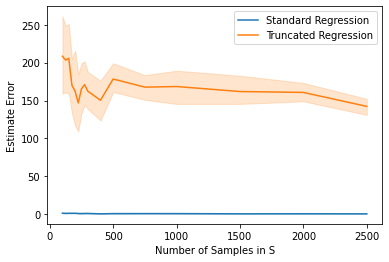

In [117]:
ax =sns.lineplot(data=ols_logs, x='num_samples', y='ols_epsilon', label='Standard Regression')
ax = sns.lineplot(data=unknown_logs, x='num_samples', y='unknown_epsilon', label='Truncated Regression')
ax.set(xlabel='Number of Samples in S', ylabel='Estimate Error')

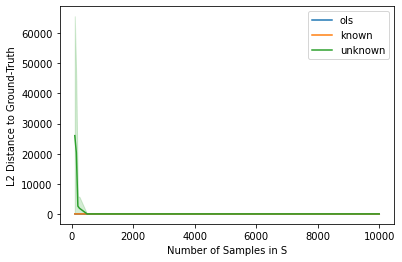

[Text(0.5, 0, 'Number of Samples in S'),
 Text(0, 0.5, 'L1 Distance to Ground-Truth')]

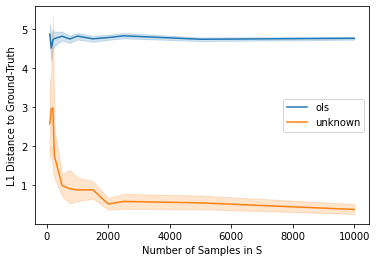

In [23]:
sns.lineplot(data=logs, x='num_samples', y='ols_param_mse', label='ols')
# sns.lineplot(data=logs, x='noise_scale', y='known_emp_param_mse', label='known emp')
ax = sns.lineplot(data=logs, x='num_samples', y='known_param_mse', label='known')
ax = sns.lineplot(data=logs, x='num_samples', y='unknown_param_mse', label='unknown')
ax.set(xlabel='Number of Samples in S', ylabel='L2 Distance to Ground-Truth')
plt.show()

sns.lineplot(data=logs, x='num_samples', y='ols_var_l1', label='ols')
ax = sns.lineplot(data=logs, x='num_samples', y='unknown_var_l1', label='unknown')
ax.set(xlabel='Number of Samples in S', ylabel='L1 Distance to Ground-Truth')

In [128]:
(scaled_kinterval(stand_y_trunc) != 1).nonzero(as_tuple=False)

tensor([], size=(0, 2), dtype=torch.int64)

In [142]:
ols_var

tensor([[6.6700]])

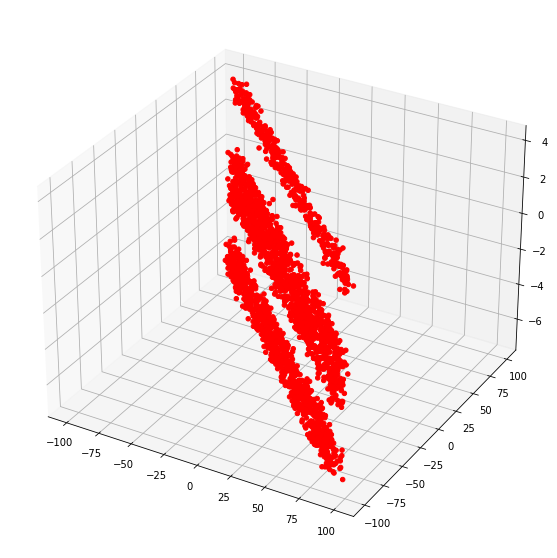

In [40]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')
# data = ch.from_numpy(np.linspace(-3.0, 3.0, 100)).unsqueeze(1).float()

# ax.scatter3D(X[:,0], X[:,1], noised, color="blue", alpha=.01)
ax.scatter3D(x_trunc[:,0], x_trunc[:,1], y_trunc, color="red", alpha=1.0)

# ax.view_init(10, -150)

In [105]:
X = np.arange(-100, 100, 1)
Y = np.arange(-100, 100, 1)
X, Y = np.meshgrid(X, Y)

pred = Tensor([])
for i in range(X.shape[0]): 
    inp = Tensor(np.concatenate([np.expand_dims(X[i], 1), np.expand_dims(Y[i], 1)], 1))
    pred = ch.cat([pred, gt(inp)], dim=1)

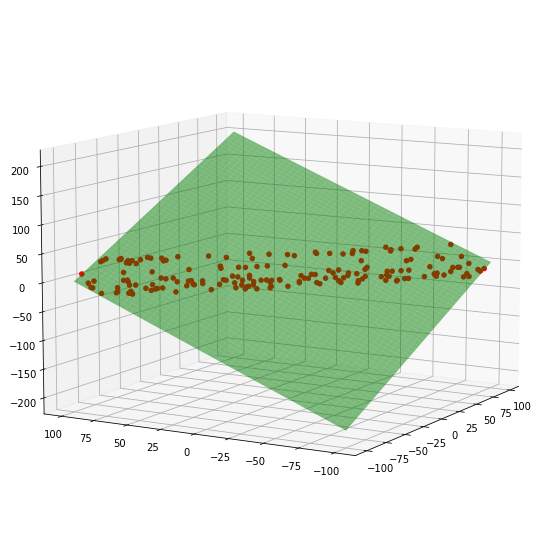

In [109]:
with ch.no_grad():
    fig = plt.figure(figsize=(10, 10))
    ax = fig.gca(projection='3d')
    ax.scatter3D(x_trunc[:,0], x_trunc[:,1], y_trunc, color="red", alpha=1.0)
    ax.plot_surface(X, Y, pred.numpy(), color='green', alpha=.5)
    
ax.view_init(10, -150)

In [107]:
s

175

In [89]:
Y.shape

(16, 16)

In [ ]:
import matplotlib.patches as mpatches
fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')
data = ch.from_numpy(np.linspace(-3.0, 3.0, 100)).unsqueeze(1).float()

ax.scatter3D(x_trunc[:,0], x_trunc[:,1], y_trunc, color="grey", alpha=.5)
with ch.no_grad():
    X = np.arange(-2, 2, 0.25)
    Y = np.arange(-2, 2, 0.25)
    X, Y = np.meshgrid(X, Y)

    # plot predicted regression
    pred = Tensor([results(Tensor(np.concatenate([np.expand_dims(X[i], 1), np.expand_dims(Y[i], 1)], 1)).float()).numpy().flatten() for i in range(X.shape[0])]).numpy()
    ax.plot_surface(X, Y, pred, color="green", alpha=.15)
    
    # plot empirical regression - obtained via OLS
    emp = np.array([S.dataset.reg.predict(np.concatenate([np.expand_dims(X[i], 1), np.expand_dims(Y[i], 1)], 1)).flatten() for i in range(X.shape[0])])
    ax.plot_surface(X, Y, emp, color="red", alpha=.15)
    
    # plot actual regression - based off of synthetic data
    act = ch.cat([(Tensor(np.concatenate([np.expand_dims(X[i], 1), np.expand_dims(Y[i], 1)], 1)).float().mm(W) + W0) for i in range(X.shape[0])], 1).numpy()
    ax.plot_surface(X, Y, act, color="blue", alpha=.15)
    


red_patch = mpatches.Patch(color='red', label='OLS')

green_patch = mpatches.Patch(color='green', label='delphi')
blue_patch = mpatches.Patch(color='blue', label="actual")
plt.legend(handles=[red_patch, blue_patch, green_patch], loc="center right")

ax.view_init(10, -150)
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

ax.set_xlabel('X_0')
ax.set_ylabel('X_1')
ax.set_zlabel('Y')

In [145]:
dist.sample(ch.Size([10000])).norm(dim=-1).max()

tensor(1.6702)

In [154]:
u = Uniform(-1/d, 1/d)

s = u.sample(ch.Size([10000, d]))

In [46]:
(x_trunc@w+w0 - y_trunc)

tensor([[-8.0481],
        [-4.1819],
        [-3.8256],
        ...,
        [ 0.5905],
        [-2.1130],
        [-1.7292]])

In [47]:
unknown_var

tensor([[9.3957]], grad_fn=<MulBackward0>)

In [44]:
x = y = np.arange(-9.5, 15.0, 0.15)
np.meshgrid(x, y)[0].shape

(164, 164)

In [44]:
ols_params

tensor([0.1744, 2.7350])

In [52]:
ch.abs((x_trunc@w + w0) - y_trunc).mean(0)

tensor([2.5809])

In [68]:
((X@w + w0) - noised).var(0)

tensor([9.8567])

In [58]:
(x_trunc@w + w0 - y_trunc).var(0)

tensor([4.2200])

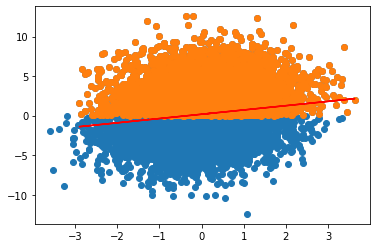

In [89]:
plt.scatter(X, noised)
plt.scatter(x_trunc, y_trunc)
plt.plot(x_trunc, x_trunc@w + w0, color='r')

In [61]:
data = Tensor(np.expand_dims(np.linspace(-3, 3), 1))

In [76]:
x_half, y_half = X[:5000], noised[:5000]

In [77]:
(x_half@w + w0 - y_half).var(0)

tensor([10.1086])

In [86]:
(x_trunc@w - y_trunc).var(0)

tensor([4.2200])

In [81]:
w0

tensor([[0.1702]])

In [24]:
rand = ch.randn(100, 16, 1)

In [25]:
rand > 0.0

tensor([[[False],
         [False],
         [False],
         ...,
         [False],
         [False],
         [ True]],

        [[ True],
         [False],
         [False],
         ...,
         [ True],
         [False],
         [False]],

        [[ True],
         [False],
         [ True],
         ...,
         [ True],
         [False],
         [False]],

        ...,

        [[False],
         [ True],
         [False],
         ...,
         [False],
         [ True],
         [ True]],

        [[False],
         [False],
         [False],
         ...,
         [ True],
         [False],
         [False]],

        [[ True],
         [False],
         [ True],
         ...,
         [ True],
         [ True],
         [False]]])